In [51]:
import glob
import numpy as np
import pandas as pd
from astropy.time import Time
import cdflib
import datetime
import spacepy.datamodel as dm
from astropy.table import Table
import math
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import tqdm

In [52]:
# estimate local time zone
def calc_solartime(longitude_local, datetime_UTC):

    longitudes = []
    for i in iter(range(0,13)):
        longitudes.append(7.5 + (15*i))    
    
    longitudes.append(np.abs(longitude_local))
    longitudes.sort()
    
    idx_localtime = np.argwhere(longitudes == np.abs(longitude_local))[0][0]
    if longitude_local >=0:
        datetime_local = datetime_UTC + datetime.timedelta(hours = int(idx_localtime))
    else:
        datetime_local = datetime_UTC - datetime.timedelta(hours = int(idx_localtime))
    
    return datetime_local

In [81]:
gf = pd.read_csv('../data/processed/GF_ts_complete_2.csv')

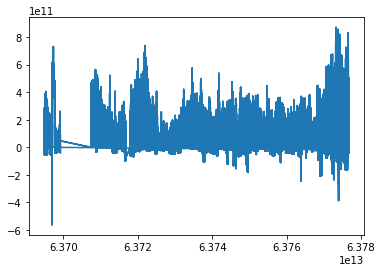

In [82]:
plt.plot(gf['CDF Epoch'], gf['Relative_Ne'])

In [83]:
gf = gf.drop_duplicates()

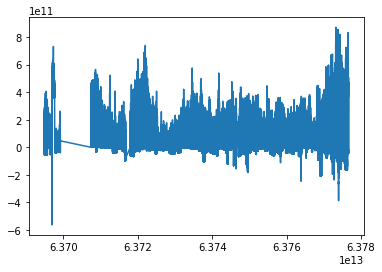

In [84]:
plt.plot(gf['CDF Epoch'], gf['Relative_Ne'])

In [85]:
gf['dates'] = (Time(gf['CDF Epoch'].values, format='cdf_epoch')).datetime

In [86]:
datetime_local = []

for i in iter(range(0,len(gf))):
    datetime_local.append(calc_solartime(gf['Longitude'][i], gf['dates'][i]))

In [87]:
gf['datetime_local'] = datetime_local

In [88]:
gf['hour'] = gf.datetime_local.apply(lambda x : x.hour)

<ipython-input-89-c6613ba2d691>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18,3))


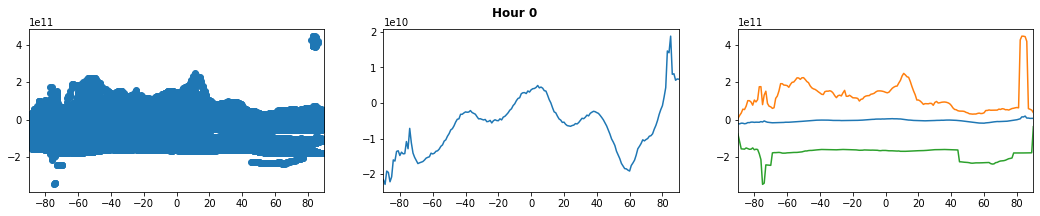

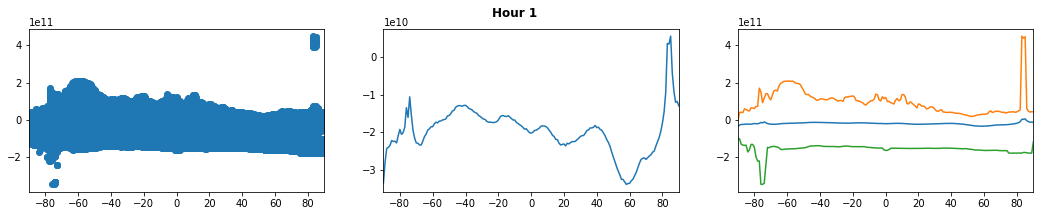

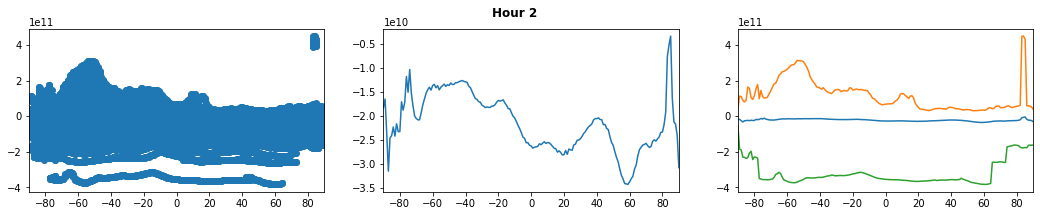

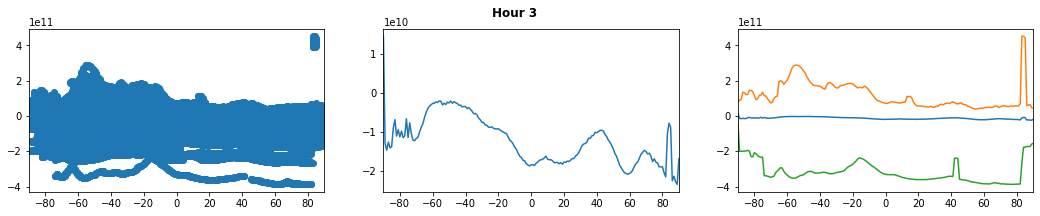

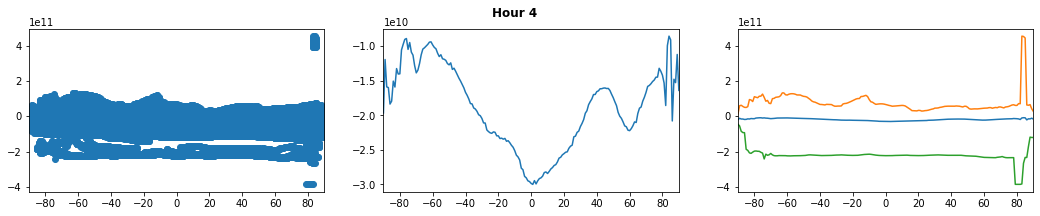

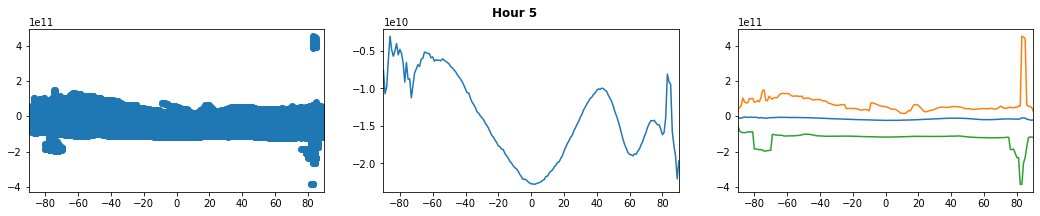

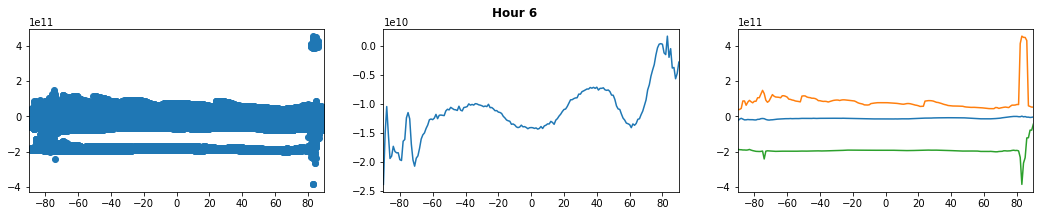

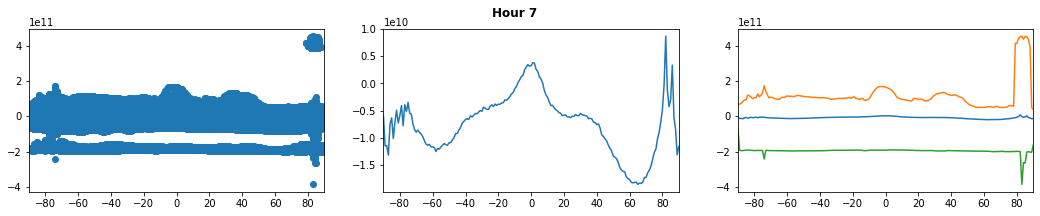

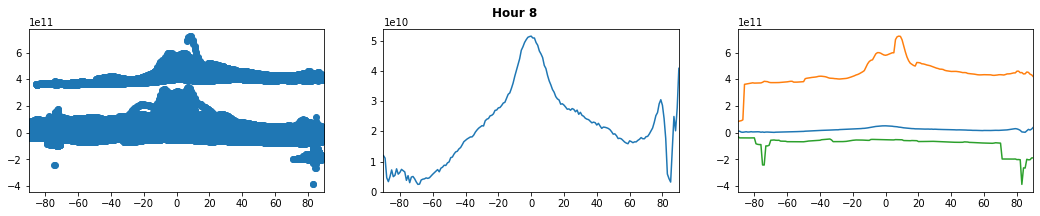

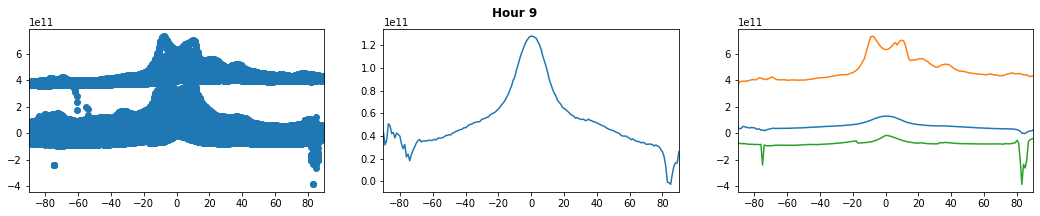

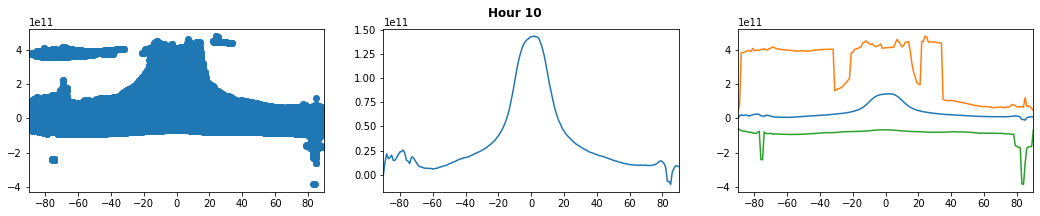

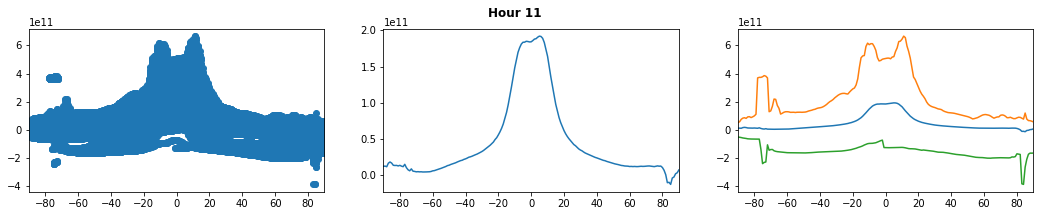

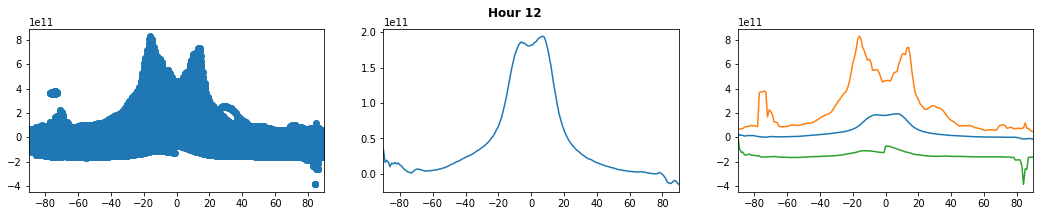

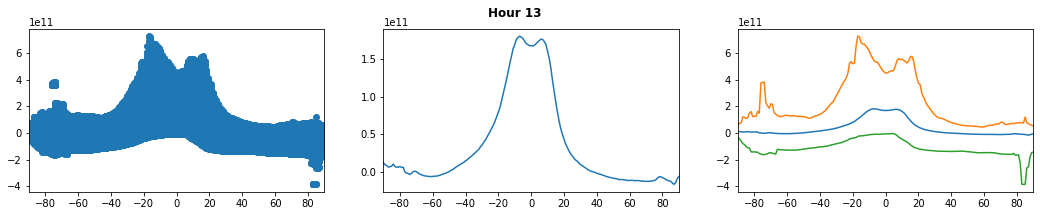

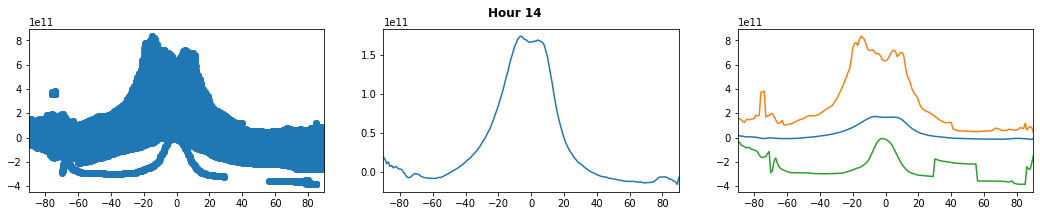

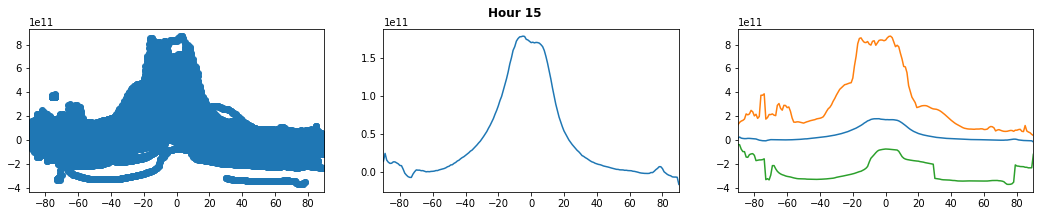

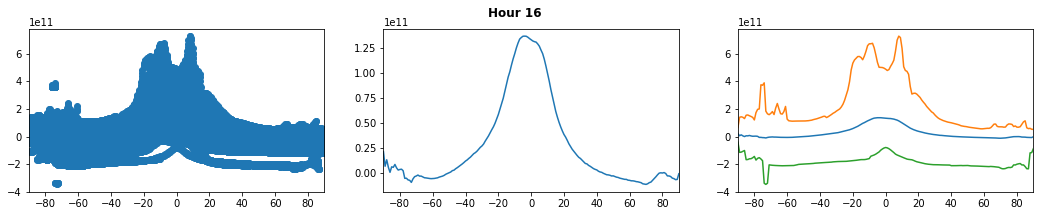

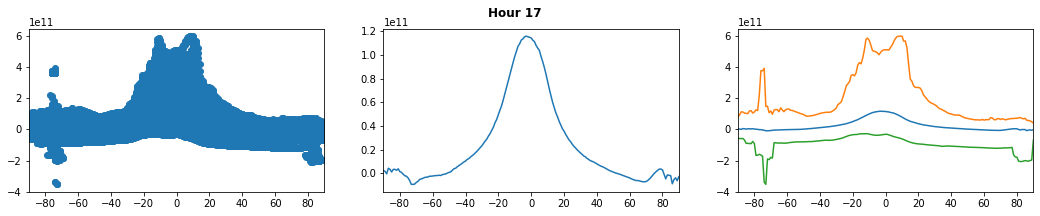

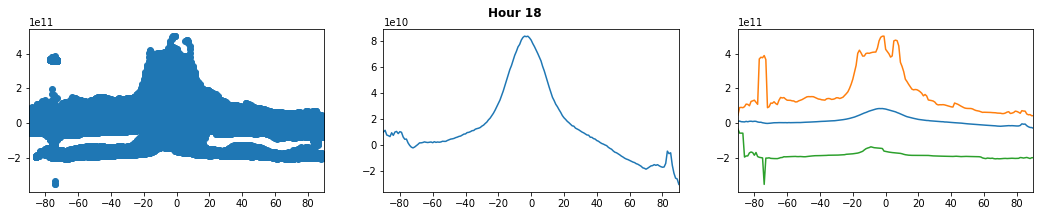

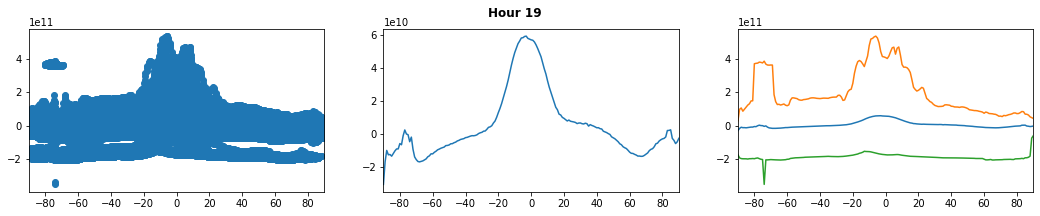

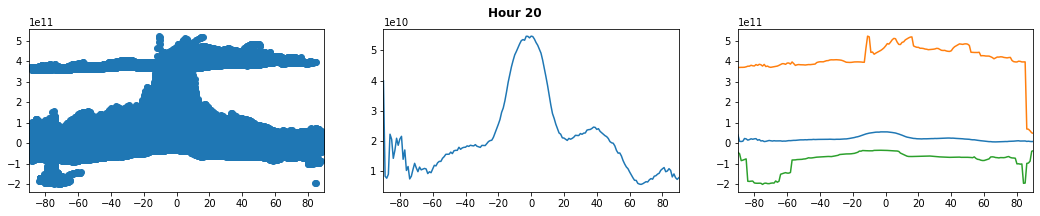

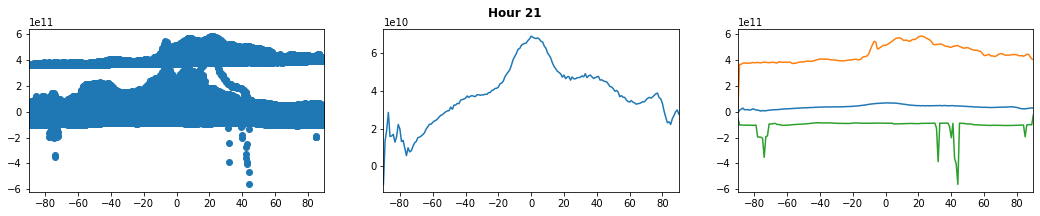

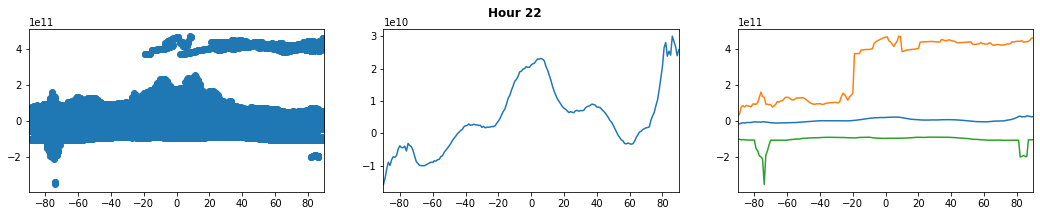

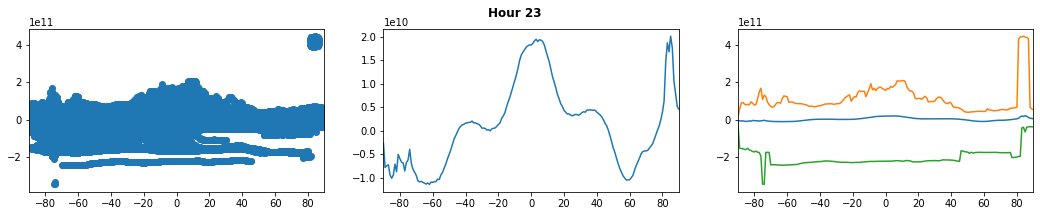

In [89]:
pd.options.mode.chained_assignment = None

# loop through hours
for i in iter(range(0,24)):
    # select hour
    gf_plot = gf[gf['hour'] == i]
    
    # bin lat
    gf_plot['Latitude_QD'] = np.round(gf_plot['Latitude_QD'],0)
    
    # extract mean, max, min
    gf_groupby = gf_plot.groupby('Latitude_QD').agg({'Relative_Ne': ['mean', 'min', 'max']})
    
#     # plot
    plt.figure(figsize=(18,3))
    plt.suptitle('Hour {i}'.format(i=i),fontweight='bold')
    
    ax = plt.subplot(1,3,1) 
    plt.scatter(gf_plot['Latitude_QD'], gf_plot['Relative_Ne']) 
    plt.xlim(-90,90)
#     plt.ylim(-10e11, 10e11)
    

    ax = plt.subplot(1,3,2) 
    plt.plot(gf_groupby.index, gf_groupby['Relative_Ne']['mean'])
    plt.xlim(-90,90)
#     plt.ylim(-10e10, 10e10)

    
    ax = plt.subplot(1,3,3) 
    plt.plot(gf_groupby.index, gf_groupby['Relative_Ne']['mean'])
    plt.plot(gf_groupby.index, gf_groupby['Relative_Ne']['max'])     
    plt.plot(gf_groupby.index, gf_groupby['Relative_Ne']['min'])     
    plt.xlim(-90,90)
#     plt.ylim(-10e11, 10e11)
    
    plt.savefig('GF_maglat_Ne_{hour}.png'.format(hour=i))




In [296]:
radar_bias = pd.read_csv('../data/processed/RADAR_CALIB_TEST_2.csv')

In [297]:
gaps = pd.read_csv('../data/interim/GRACEFO/KBRNE_relative_v2/aux_files/GRACE-FO-GAP-BIAS.ARC',sep='\s+')

In [389]:
gaps = gaps[gaps['new_ARC'] == 1]

,YYYY,DDD,GPSS-GRACE,delta_ARC0,CDF_Epoch,new_ARC,dates
0,2018,149,580863915,392872.083520,63694811097000,1,2018-05-29 11:04:57
1,2018,158,581654310,982182.156931,63695601492000,1,2018-06-07 14:38:12
2,2018,166,582323910,-192479.247984,63696271092000,1,2018-06-15 08:38:12
3,2018,166,582328015,-2.516832,63696275197000,1,2018-06-15 09:46:37
4,2018,173,582967560,-2.510902,63696914742000,1,2018-06-22 19:25:42
...,...,...,...,...,...,...,...
282,2020,360,662162180,579476.215503,63776109362000,1,2020-12-25 09:56:02
283,2020,361,662235845,209278.863233,63776183027000,1,2020-12-26 06:23:47
284,2020,361,662247100,399816.617235,63776194282000,1,2020-12-26 09:31:22
285,2020,363,662441000,340584.078476,63776388182000,1,2020-12-28 15:23:02


In [300]:
radar_bias['dates'] = (Time(radar_bias['cdf-epoch'].values, format='cdf_epoch')).datetime

In [301]:
radar_bias

,Unnamed: 0,cdf-epoch,radar,radar_ne,radar_nprofiles,gf_ne,dates
0,0,6.373118e+13,MillstoneHillISRadar,1.568349e+10,10,-3.334140e+10,2019-07-24 08:25:07.000
1,1,6.369561e+13,MillstoneHillISRadar,4.562118e+10,3,4.376315e+10,2018-06-07 15:44:04.500
2,2,6.369561e+13,MillstoneHillISRadar,4.082378e+10,3,4.376315e+10,2018-06-07 15:44:04.500
3,3,6.374771e+13,MillstoneHillISRadar,2.776928e+10,10,-2.121579e+10,2020-01-31 18:23:59.500
4,4,6.369612e+13,MillstoneHillISRadar,7.870136e+10,9,3.393416e+10,2018-06-13 15:10:12.000
...,...,...,...,...,...,...,...
326,326,6.371091e+13,EISCATTromsoVHFISradar,1.866895e+10,33,5.565716e+09,2018-12-01 20:08:34.500
327,327,6.370910e+13,EISCATTromsoVHFISradar,4.703271e+10,33,1.341862e+10,2018-11-10 21:21:17.000
328,328,6.376802e+13,EISCATTromsoVHFISradar,1.645969e+10,31,-7.246060e+09,2020-09-22 18:21:07.000
329,329,6.373710e+13,EISCATTromsoVHFISradar,3.660581e+09,33,-1.219887e+10,2019-09-30 21:39:17.000


In [302]:
gf[gf['CDF Epoch'] == real_gaps['CDF_Epoch'][1]].index

Int64Index([157980], dtype='int64')

In [393]:
arc = []
radar_cdf_epoch = []
radar_name = []
radar_profiles = []
radar_ne = []
gf_ne = []


for i in iter(range(0,len(real_gaps))):
    try:
        idx = gf[gf['CDF Epoch'] == real_gaps['CDF_Epoch'][i]].index
        idy = gf[gf['CDF Epoch'] == real_gaps['CDF_Epoch'][i+1]].index-1
                
        radar_bias_mean = radar_bias[(radar_bias['cdf-epoch'] >= real_gaps['CDF_Epoch'][i]) & (radar_bias['cdf-epoch'] < real_gaps['CDF_Epoch'][i+1])]
        
        if len(radar_bias_mean) >0:

            for j in iter(range(0,len(radar_bias_mean))):
                arc.append(i)
                radar_cdf_epoch.append(radar_bias_mean['cdf-epoch'][radar_bias_mean.index[j]])
                radar_name.append(radar_bias_mean['radar'][radar_bias_mean.index[j]])
                radar_profiles.append(radar_bias_mean['radar_nprofiles'][radar_bias_mean.index[j]])
                radar_ne.append(radar_bias_mean['radar_ne'][radar_bias_mean.index[j]])
                gf_ne.append(radar_bias_mean['gf_ne'][radar_bias_mean.index[j]])        

    except:
        pass

GF_RADAR_CALIB = pd.DataFrame({'arc':arc,
             'radar_cdf_epoch': radar_cdf_epoch,
             'radar_name': radar_name,
             'radar_profiles' : radar_profiles,
             'radar_ne':radar_ne,
             'gf_ne':gf_ne})

GF_RADAR_CALIB['mean_offset']  = GF_RADAR_CALIB['radar_ne'] - GF_RADAR_CALIB['gf_ne'] 

In [395]:
real_gaps

,YYYY,DDD,GPSS-GRACE,delta_ARC0,CDF_Epoch,new_ARC,dates
0,2018,149,580863915,392872.083520,63694811097000,1,2018-05-29 11:04:57
1,2018,158,581654310,982182.156931,63695601492000,1,2018-06-07 14:38:12
2,2018,166,582323910,-192479.247984,63696271092000,1,2018-06-15 08:38:12
3,2018,166,582328015,-2.516832,63696275197000,1,2018-06-15 09:46:37
4,2018,173,582967560,-2.510902,63696914742000,1,2018-06-22 19:25:42
...,...,...,...,...,...,...,...
282,2020,360,662162180,579476.215503,63776109362000,1,2020-12-25 09:56:02
283,2020,361,662235845,209278.863233,63776183027000,1,2020-12-26 06:23:47
284,2020,361,662247100,399816.617235,63776194282000,1,2020-12-26 09:31:22
285,2020,363,662441000,340584.078476,63776388182000,1,2020-12-28 15:23:02


Text(0.5, 1.0, 'All Conjunctions - Before Calibration')

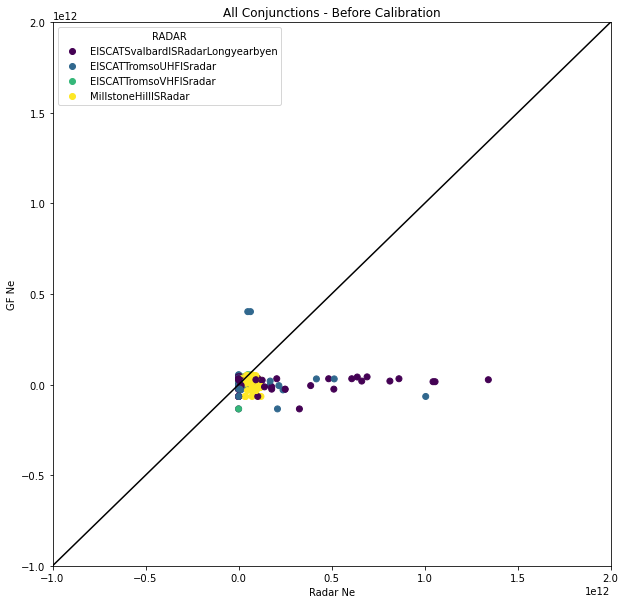

In [372]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = plt.scatter((GF_RADAR_CALIB['radar_ne']),(GF_RADAR_CALIB['gf_ne']), c =GF_RADAR_CALIB.radar_name.astype('category').cat.codes)
plt.xlim(-0.1e13,0.2e13)
plt.ylim(-0.1e13,0.2e13)

plt.legend(handles=scatter.legend_elements()[0], 
           labels=classes,
           title="RADAR")
ax.axline((1, 1), slope=1, color = 'k' )
plt.xlabel('Radar Ne')
plt.ylabel('GF Ne')
plt.title('All Conjunctions - Before Calibration')


In [342]:
arcs_offset = GF_RADAR_CALIB.groupby(["arc"])["mean_offset"].mean()
GF_RADAR_CALIB['new_offset'] = GF_RADAR_CALIB['mean_offset']

for arc in GF_RADAR_CALIB['arc']:
    GF_RADAR_CALIB['new_offset'][arc] = GF_RADAR_CALIB['new_offset'][arc] + arcs_offset[arc]


Text(0, 0.5, 'GF Nel')

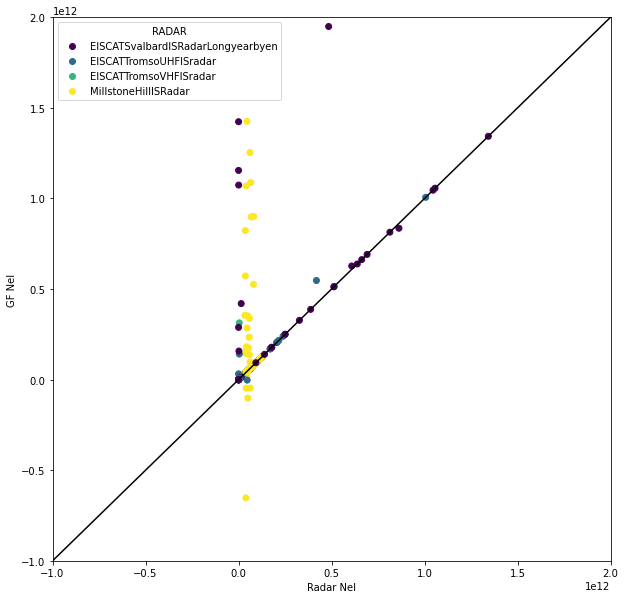

In [371]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = plt.scatter((GF_RADAR_CALIB['radar_ne']),(GF_RADAR_CALIB['gf_ne']+GF_RADAR_CALIB['new_offset']), c =GF_RADAR_CALIB.radar_name.astype('category').cat.codes)
plt.xlim(-0.1e13,0.2e13)
plt.ylim(-0.1e13,0.2e13)

plt.legend(handles=scatter.legend_elements()[0], 
           labels=classes,
           title="RADAR")
ax.axline((1, 1), slope=1, color = 'k' )
plt.xlabel('Radar Nel')
plt.ylabel('GF Nel')

In [373]:
arcs = np.unique(GF_RADAR_CALIB['arc'])

<ipython-input-377-c306a5d2f73c>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10))


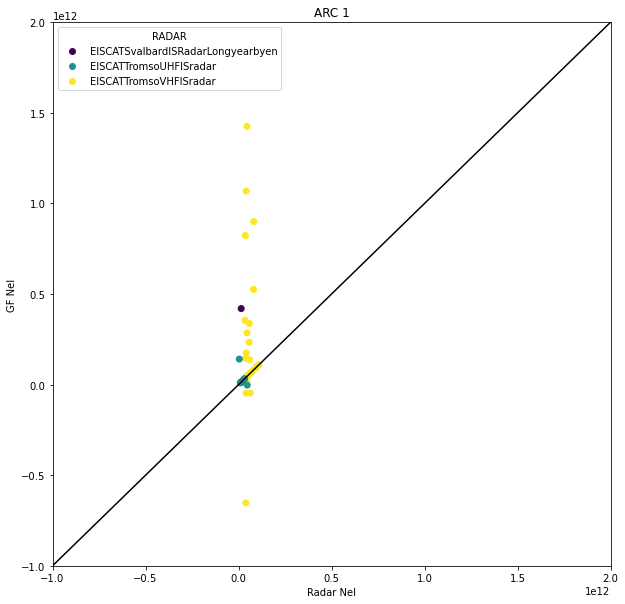

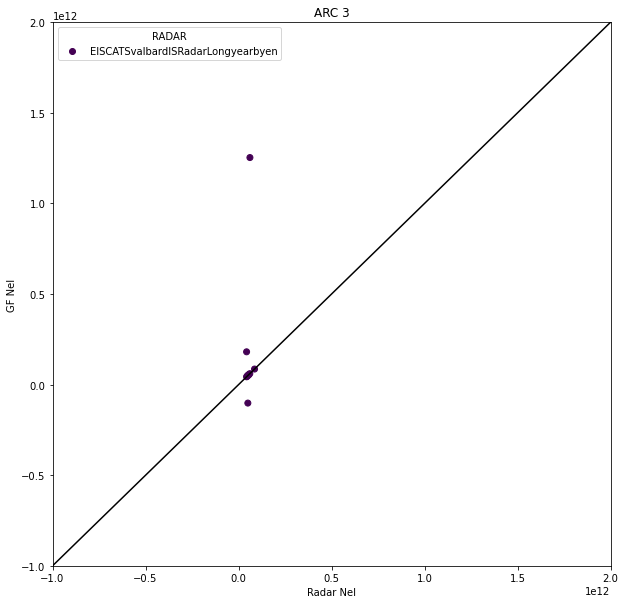

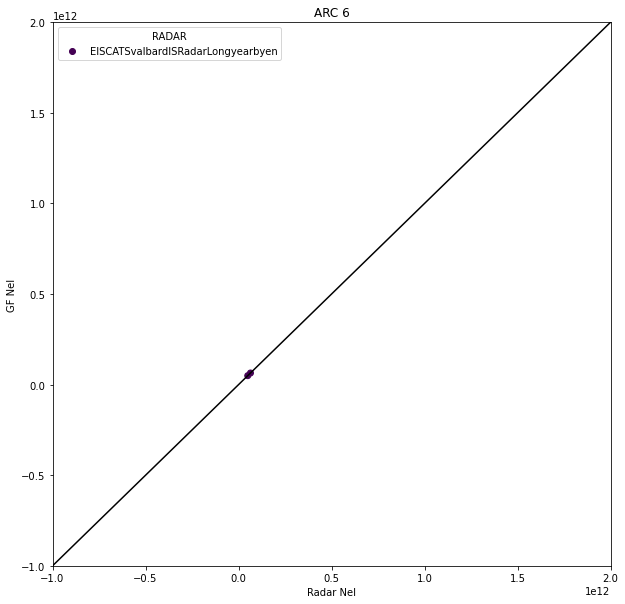

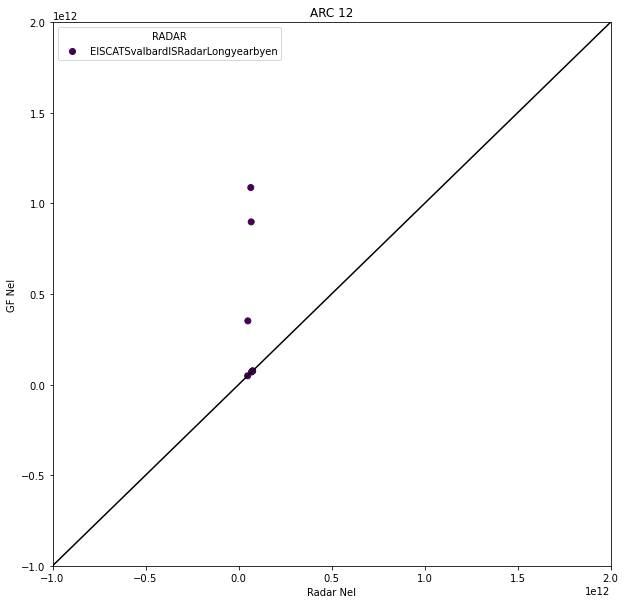

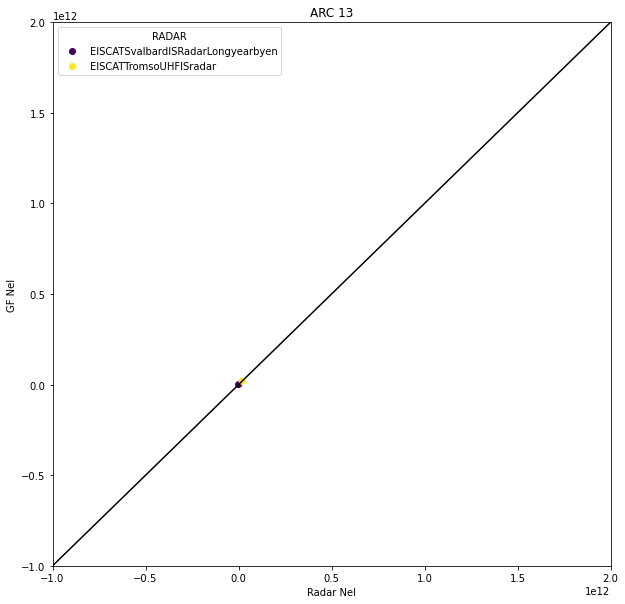

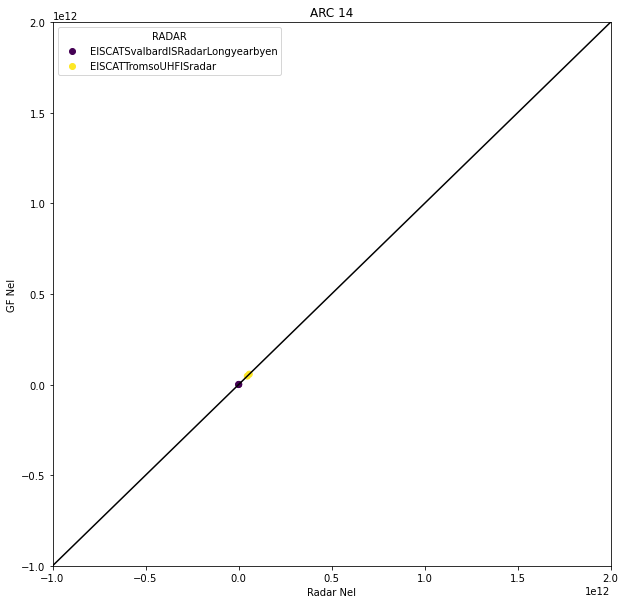

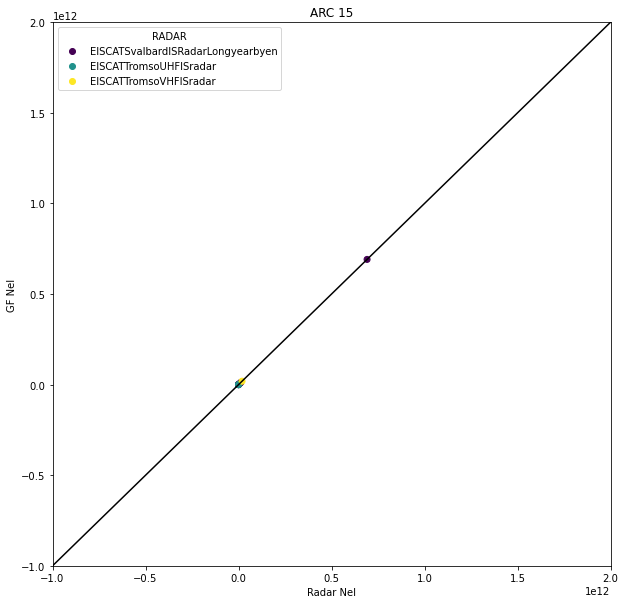

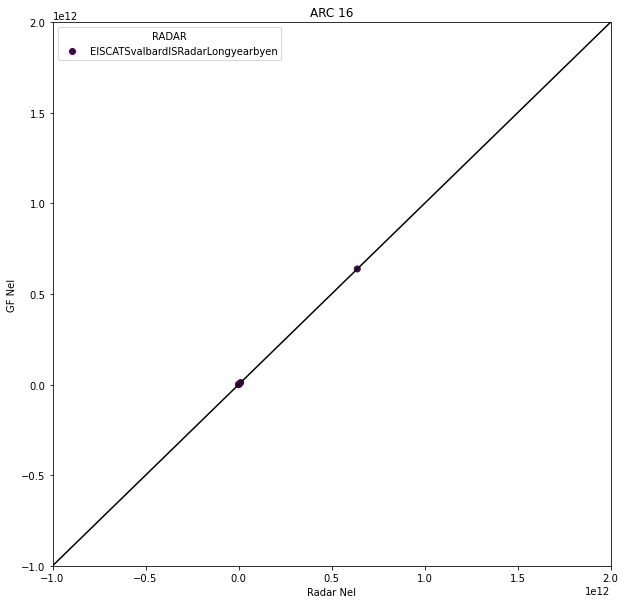

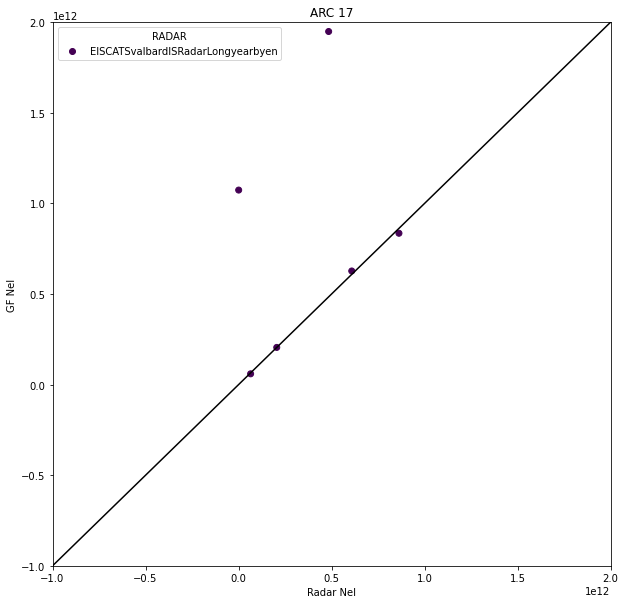

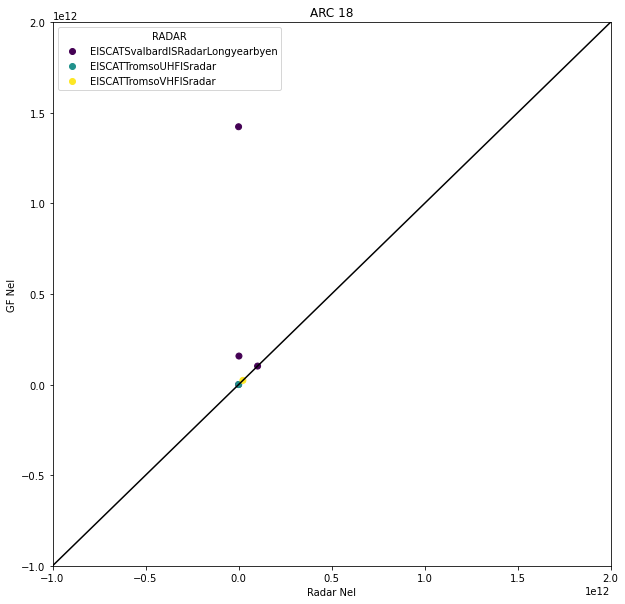

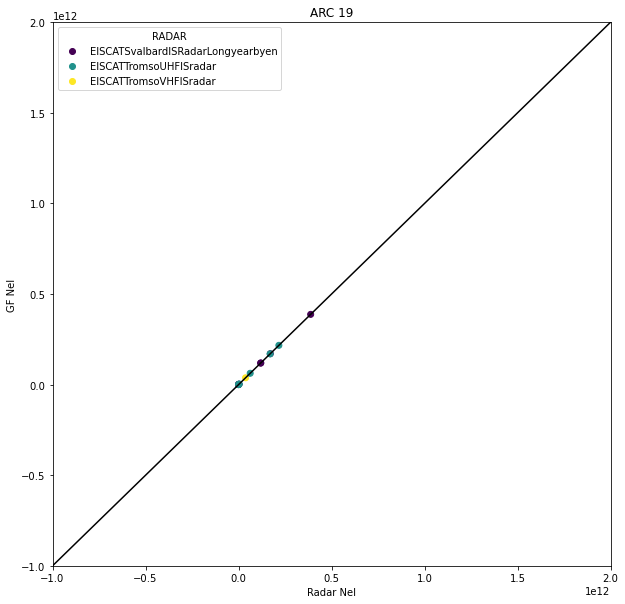

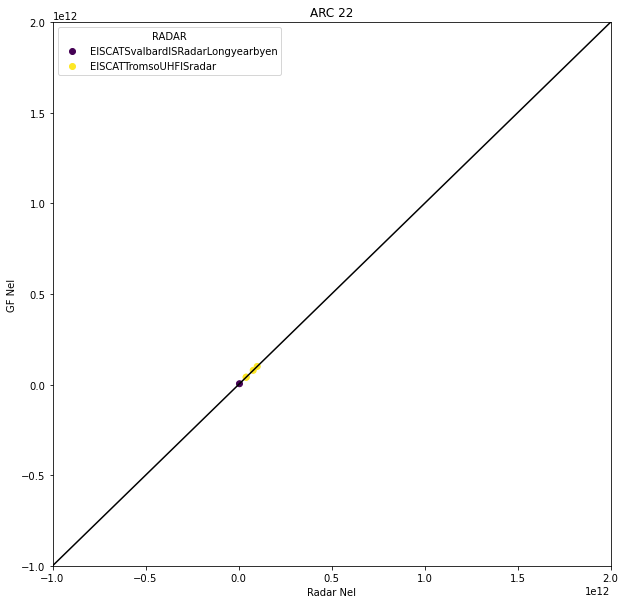

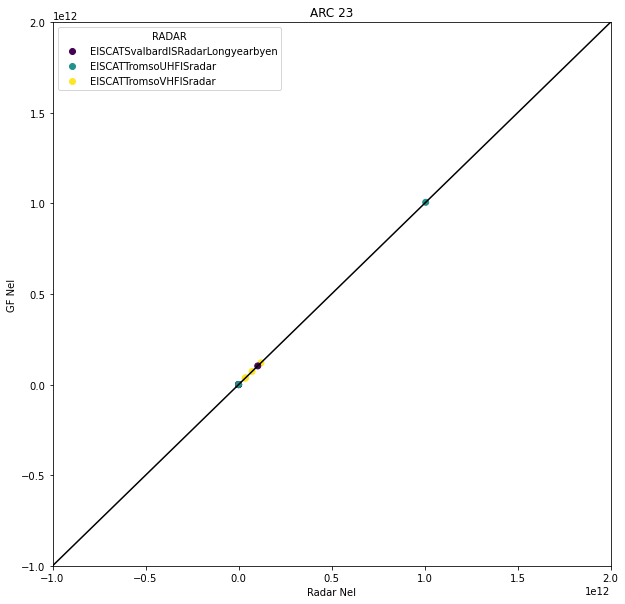

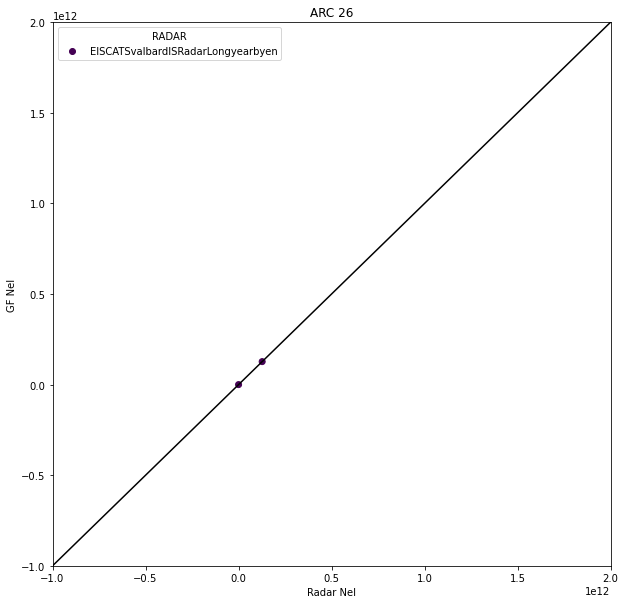

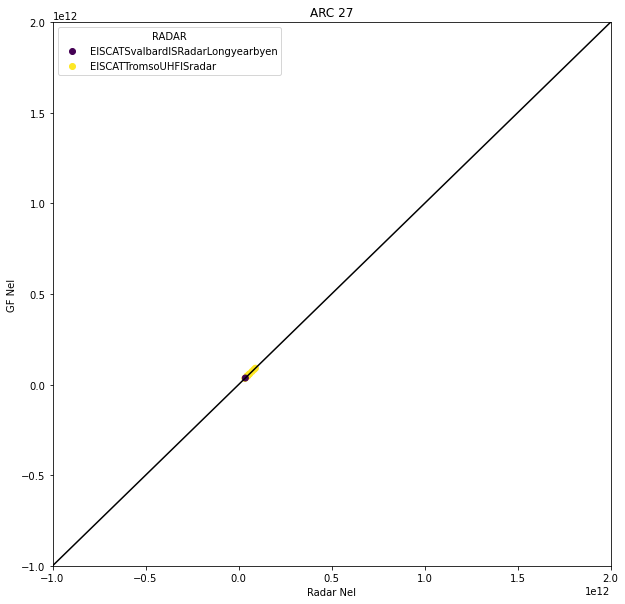

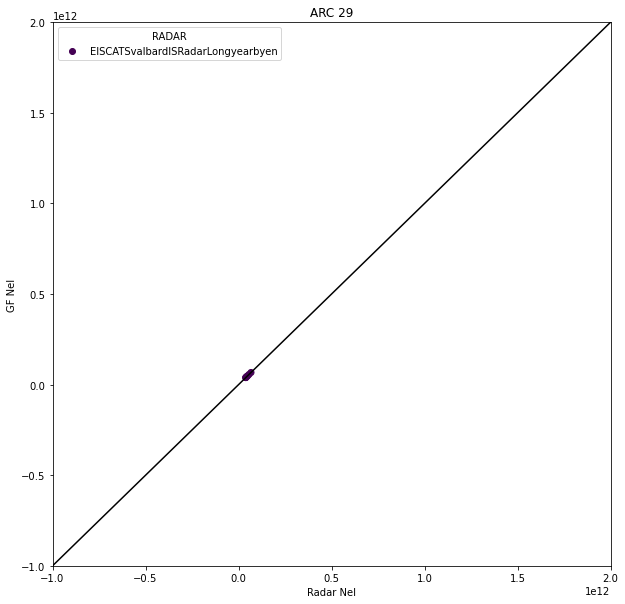

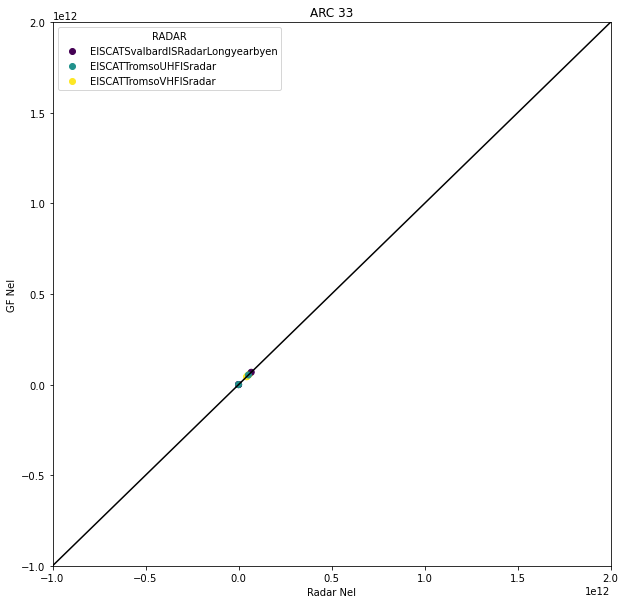

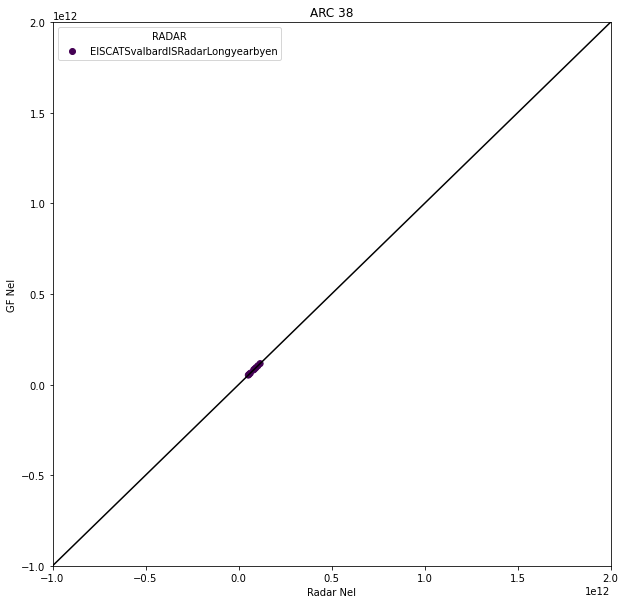

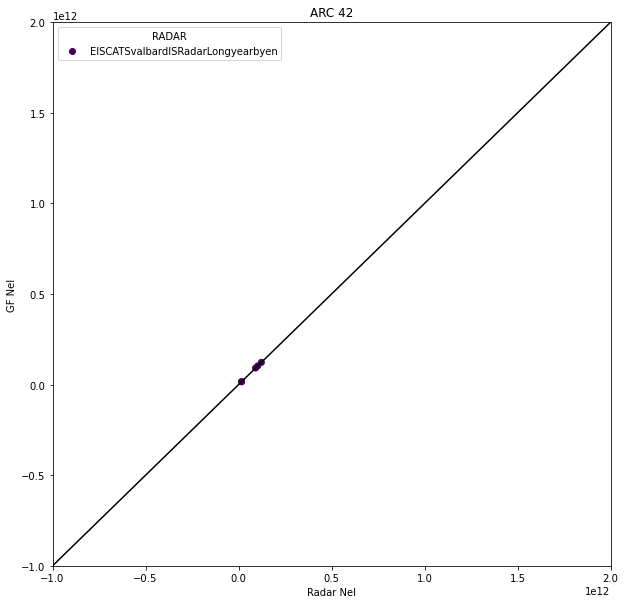

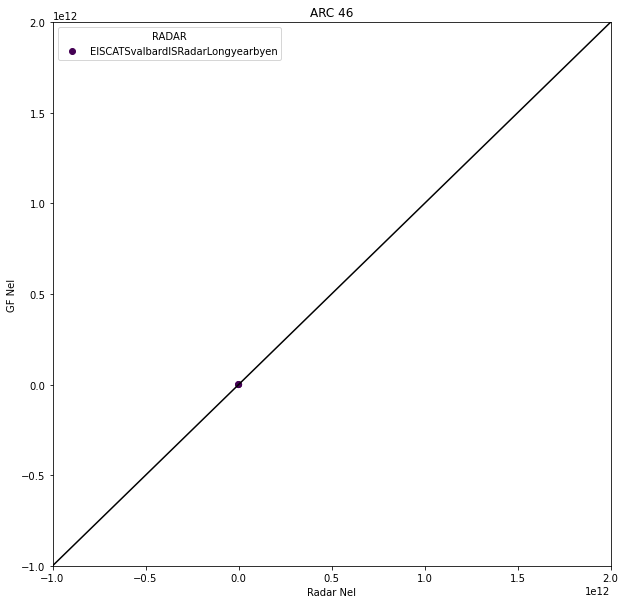

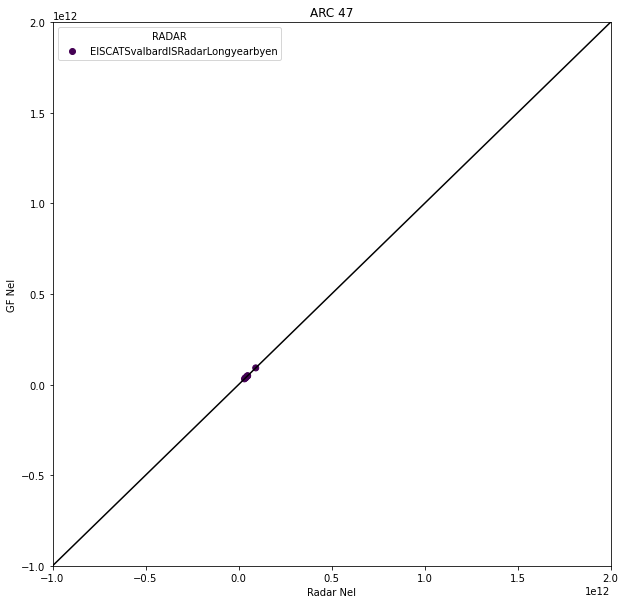

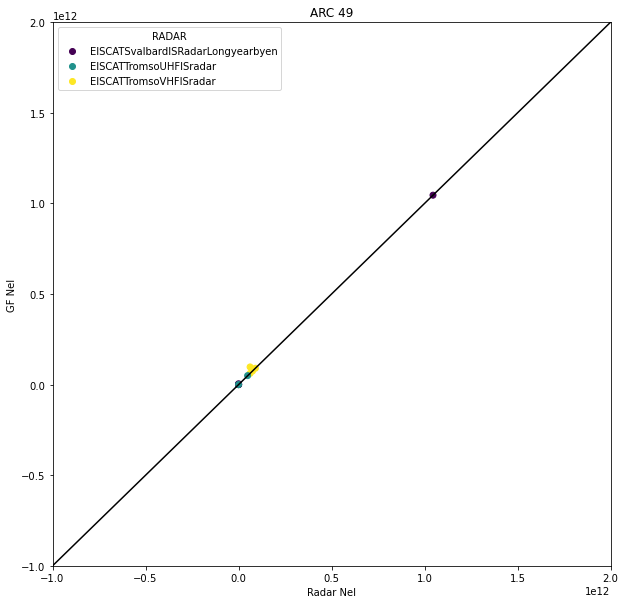

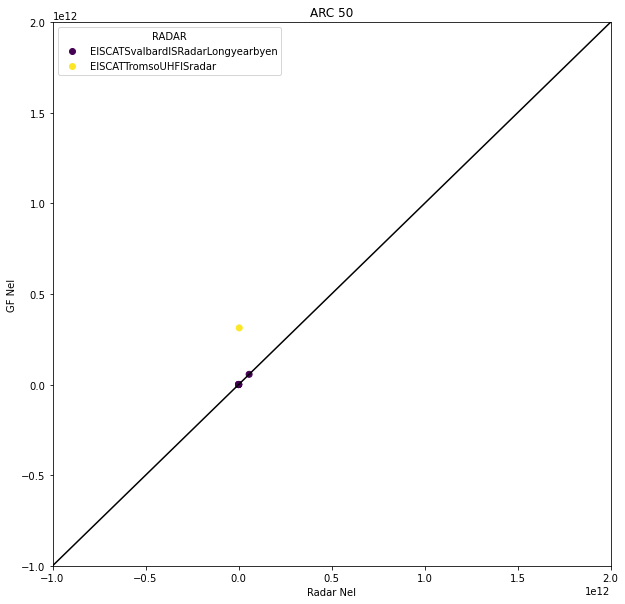

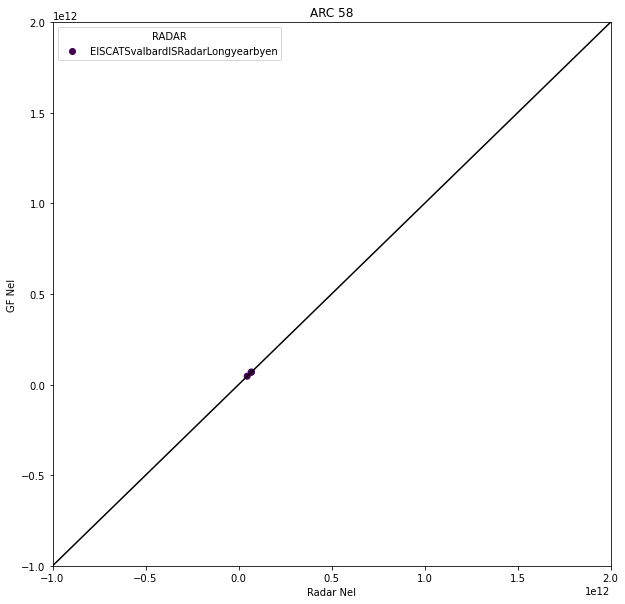

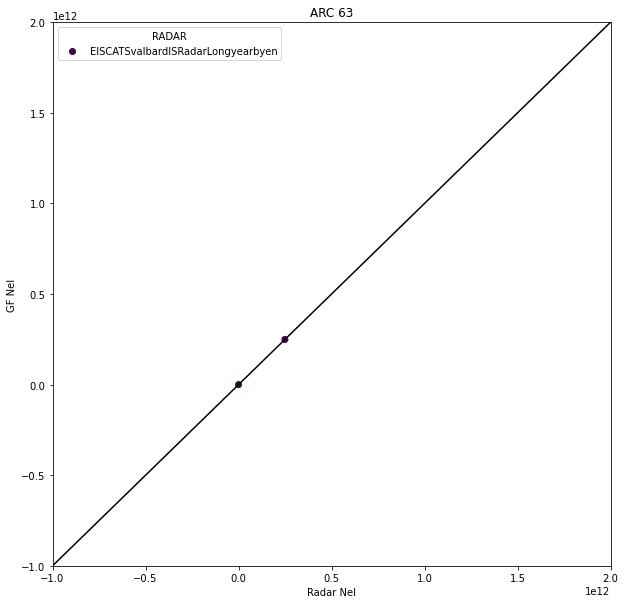

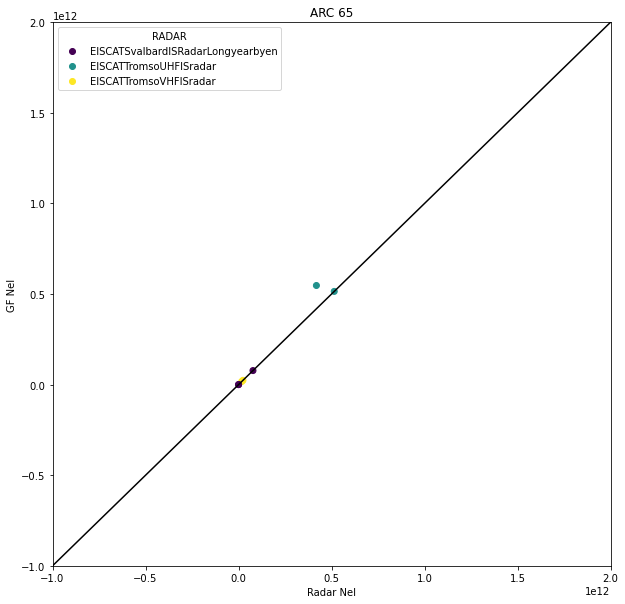

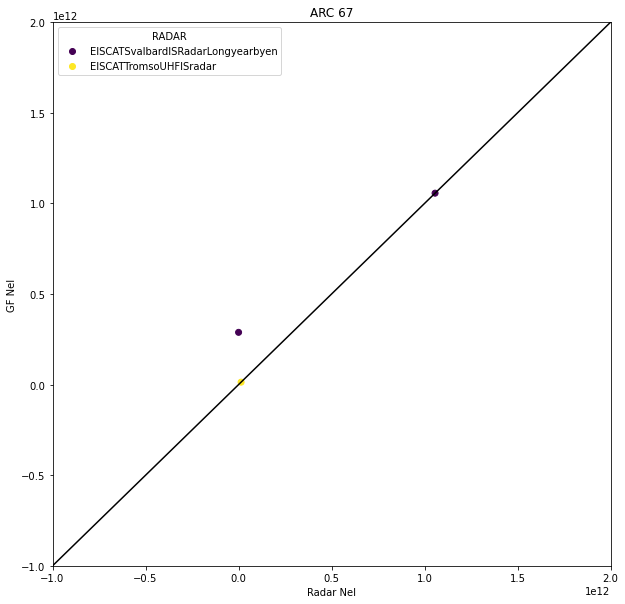

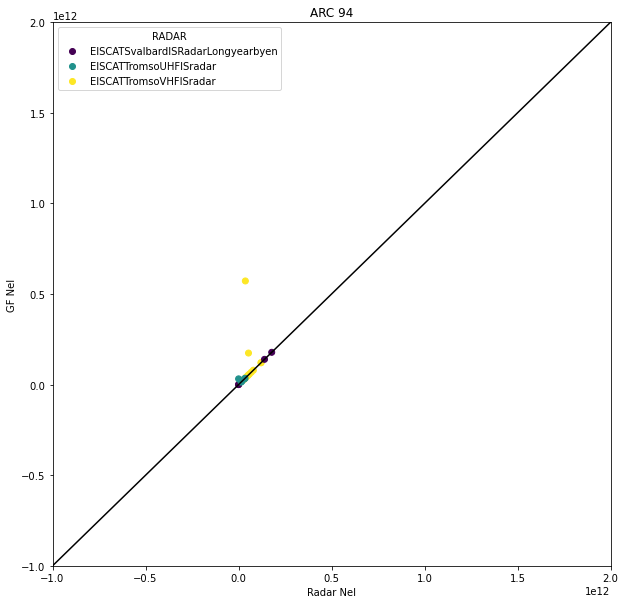

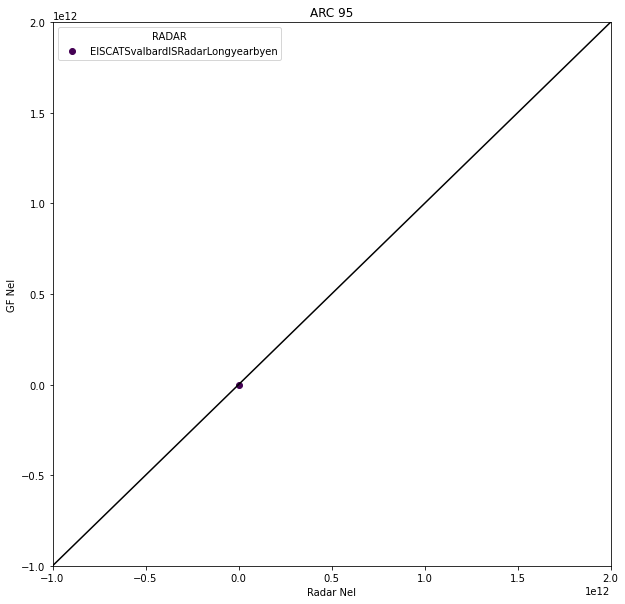

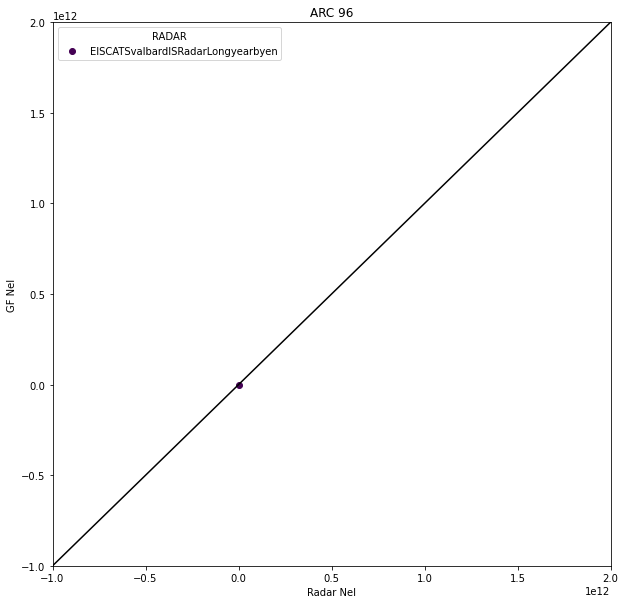

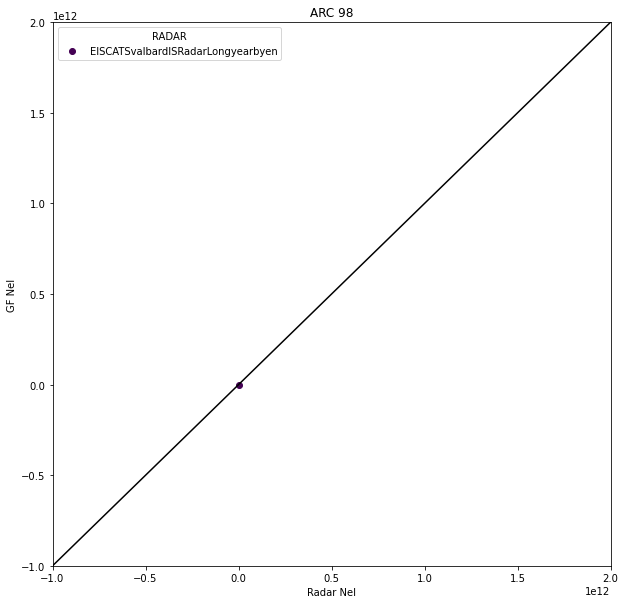

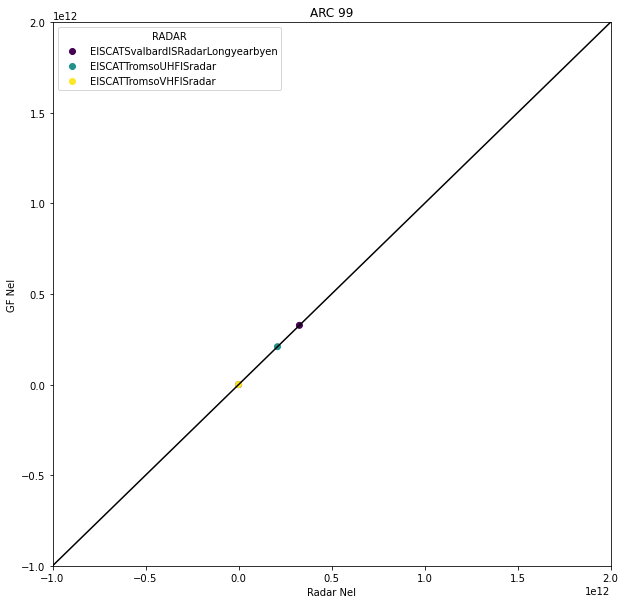

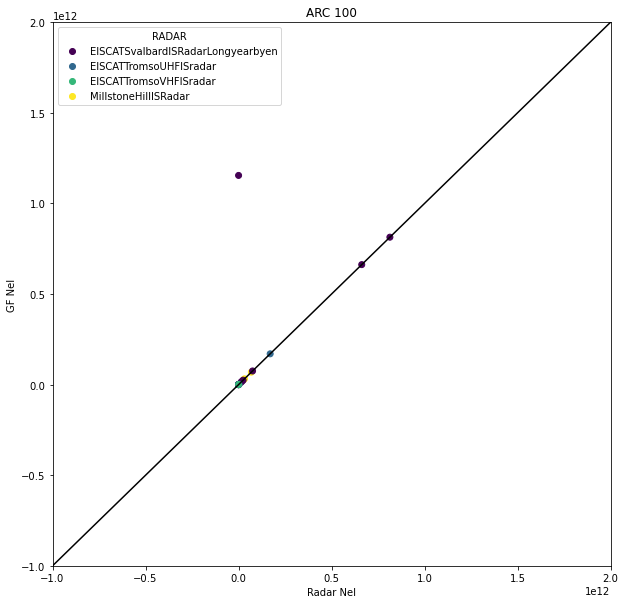

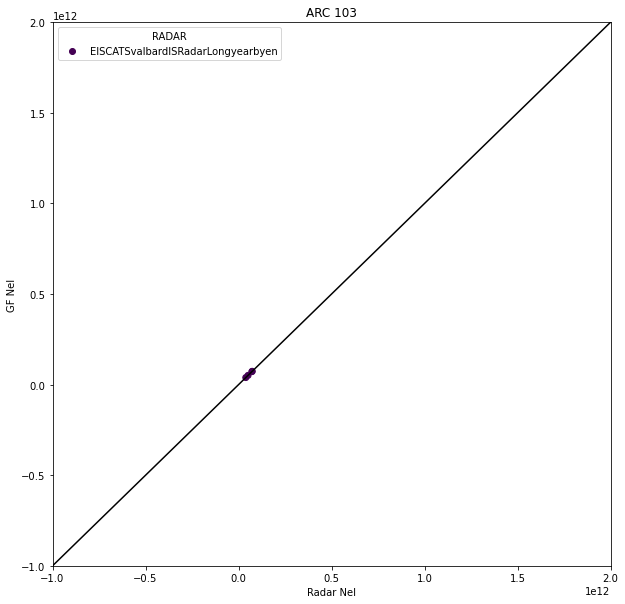

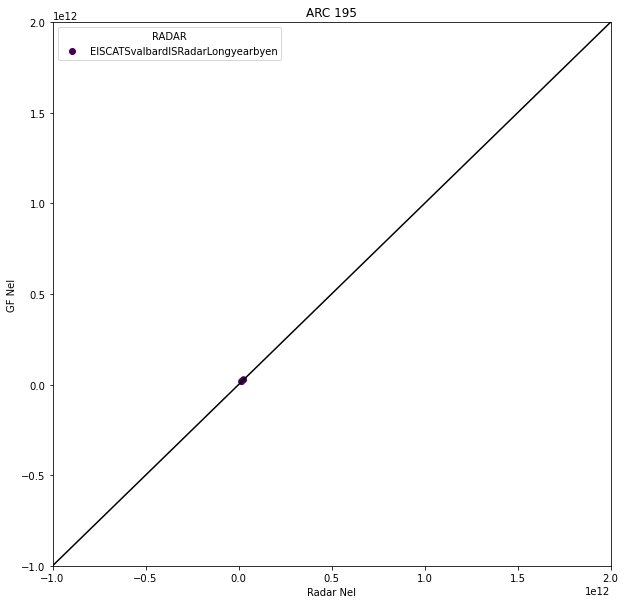

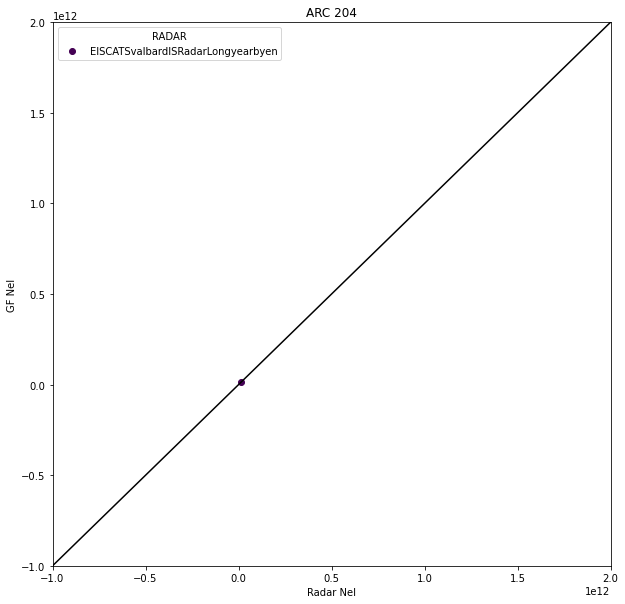

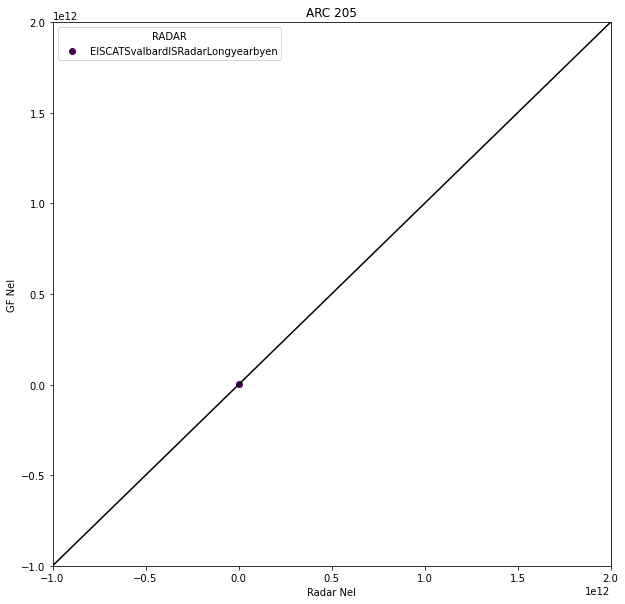

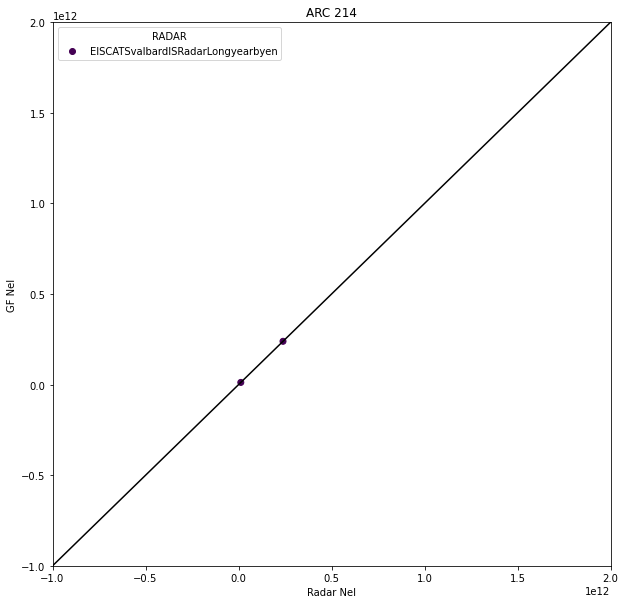

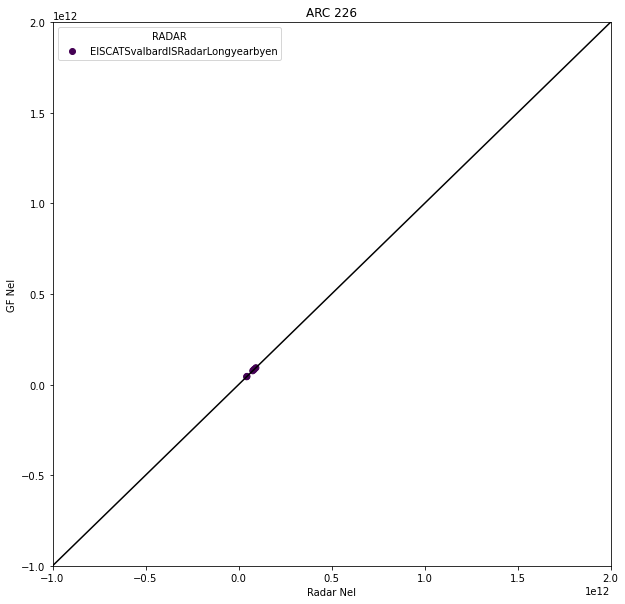

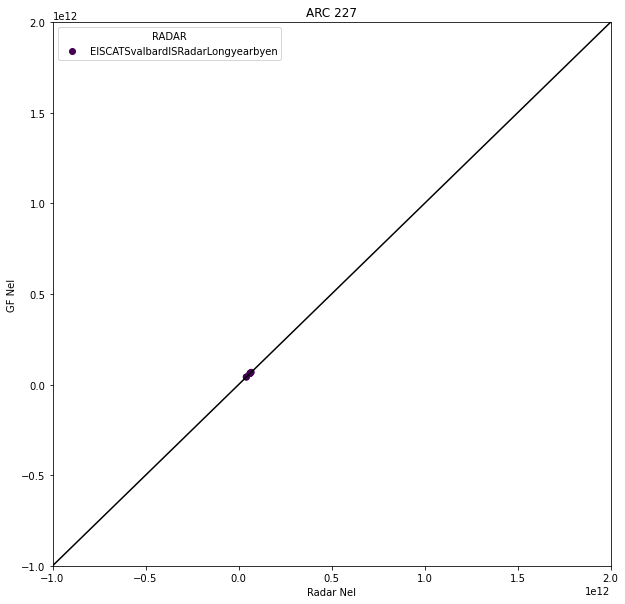

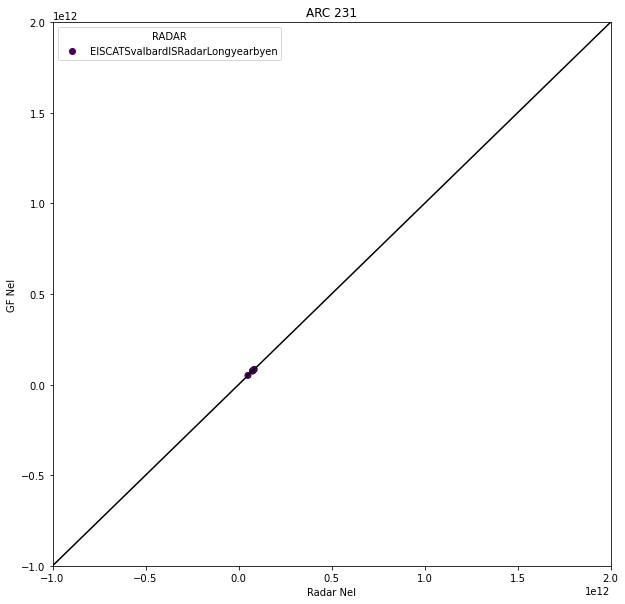

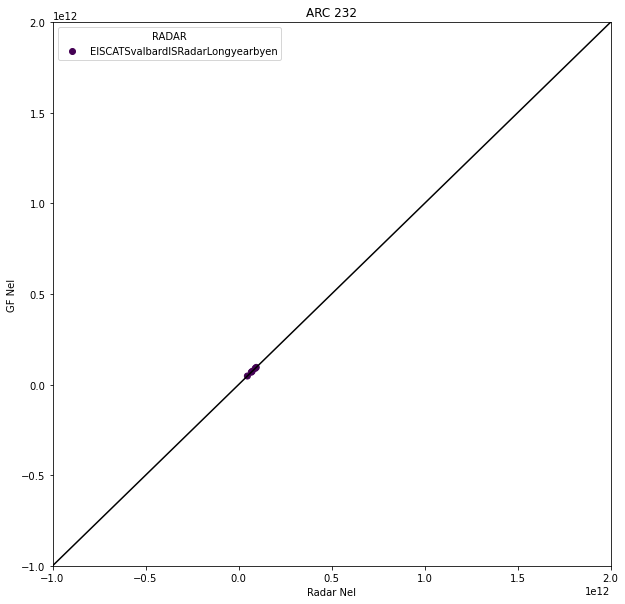

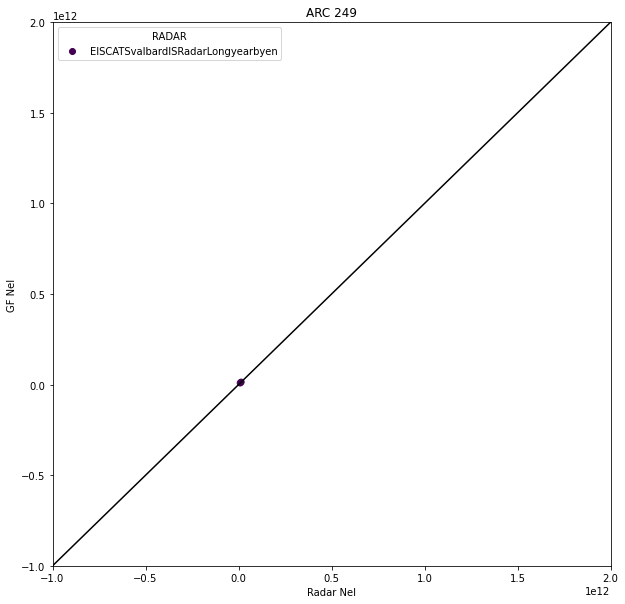

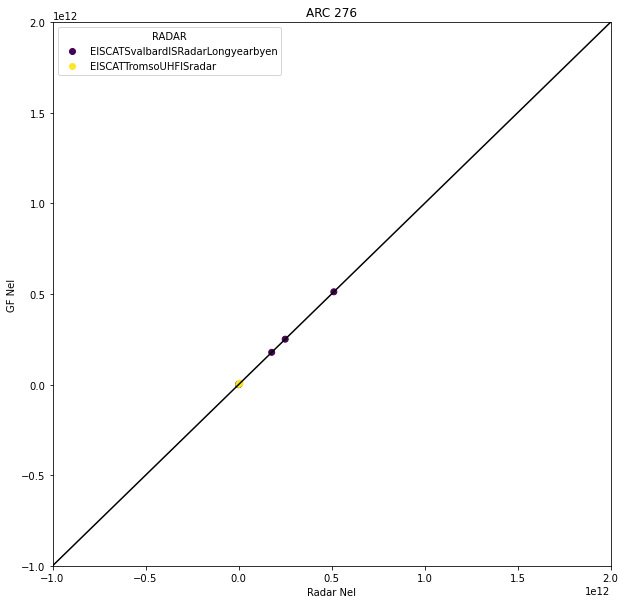

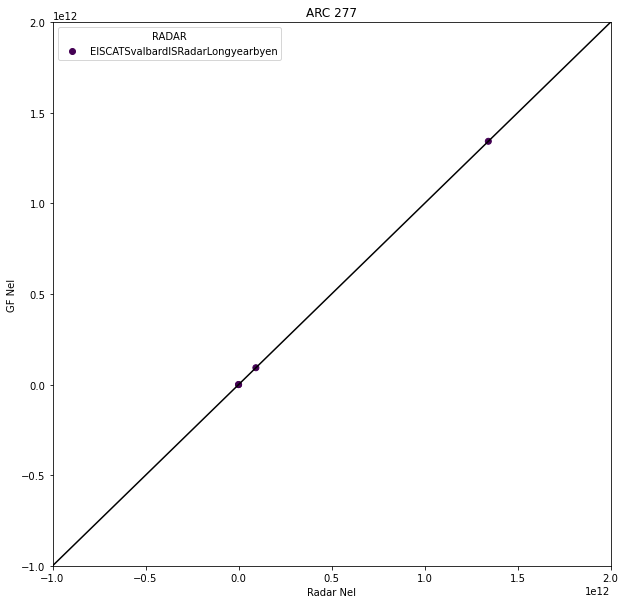

In [377]:
for arc in arcs:
    fig, ax = plt.subplots(figsize=(10,10))
    GF_RADAR_CALIB_plot = GF_RADAR_CALIB[GF_RADAR_CALIB['arc'] == arc]
    scatter = plt.scatter((GF_RADAR_CALIB_plot['radar_ne']),(GF_RADAR_CALIB_plot['gf_ne']+GF_RADAR_CALIB_plot['new_offset']), c =GF_RADAR_CALIB_plot.radar_name.astype('category').cat.codes)
    plt.xlim(-0.1e13,0.2e13)
    plt.ylim(-0.1e13,0.2e13)

    plt.legend(handles=scatter.legend_elements()[0], 
               labels=classes,
               title="RADAR")
    ax.axline((1, 1), slope=1, color = 'k' )
    plt.xlabel('Radar Nel')
    plt.ylabel('GF Nel')
    plt.title('ARC {n}'.format(n=arc))

<ipython-input-378-7c9a4df9e56b>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10))


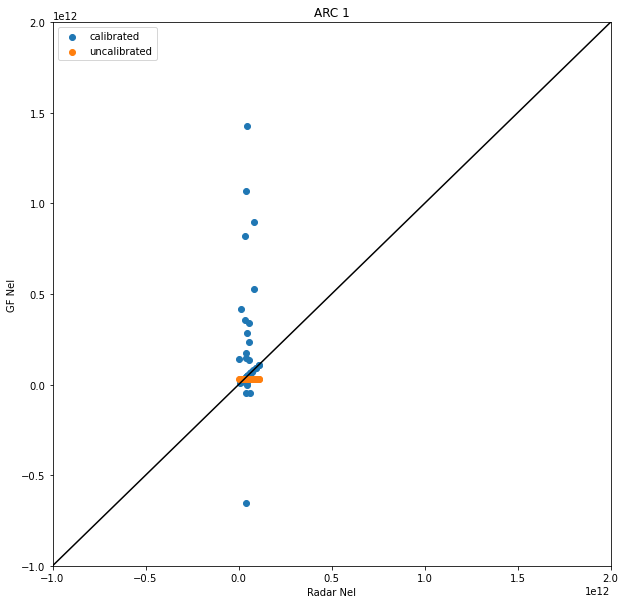

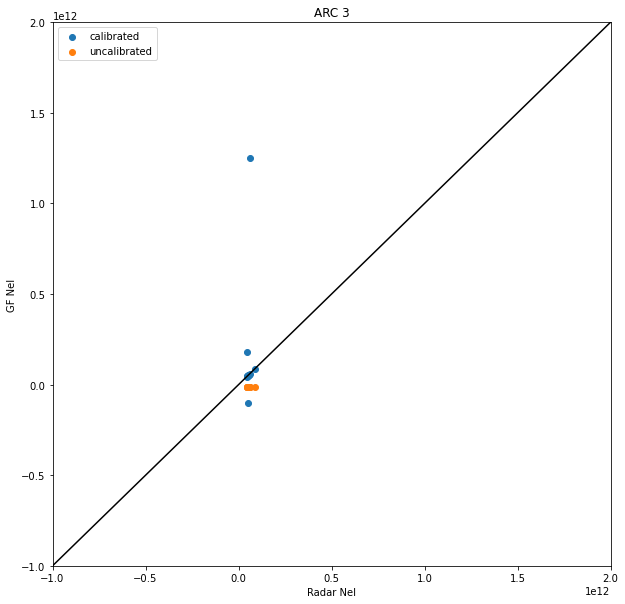

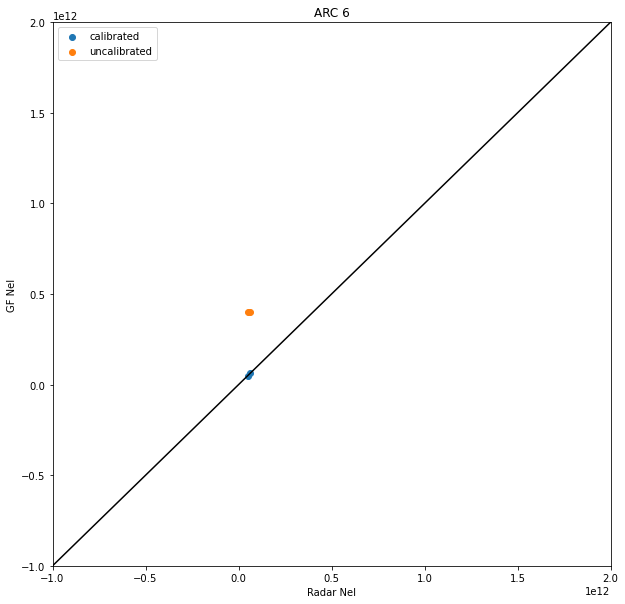

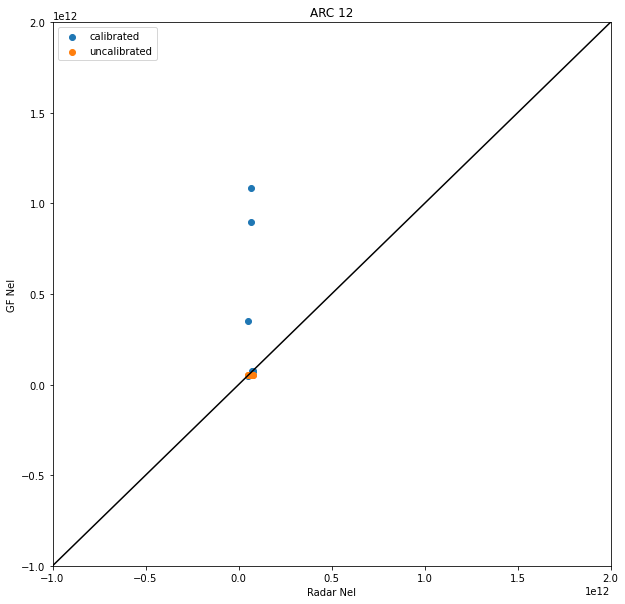

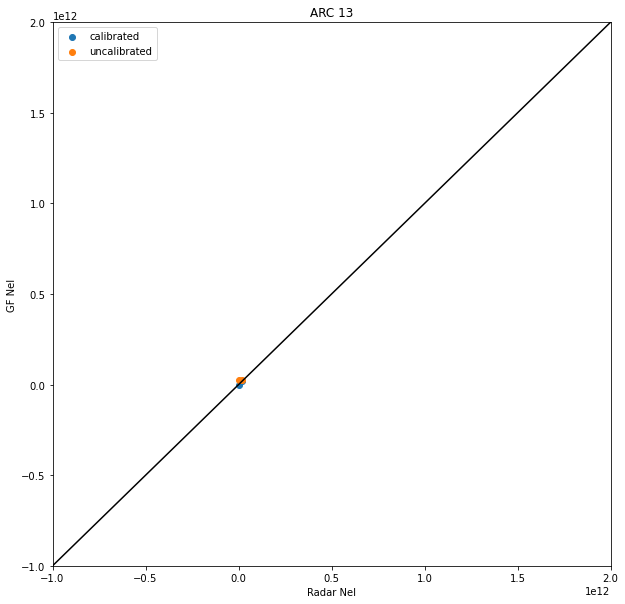

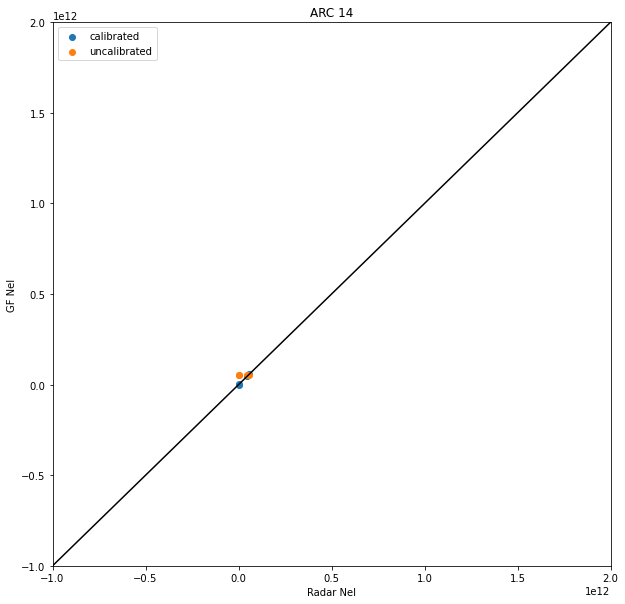

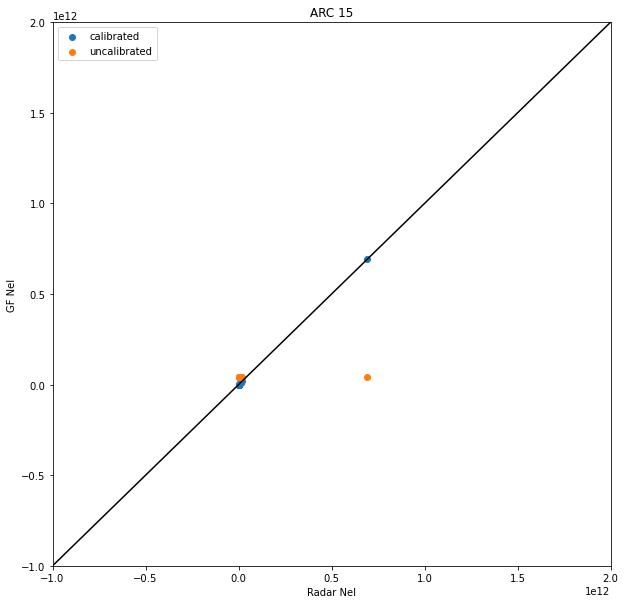

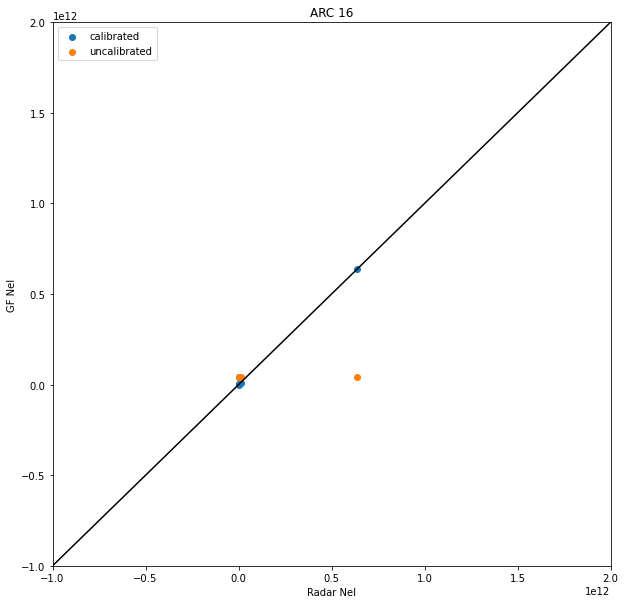

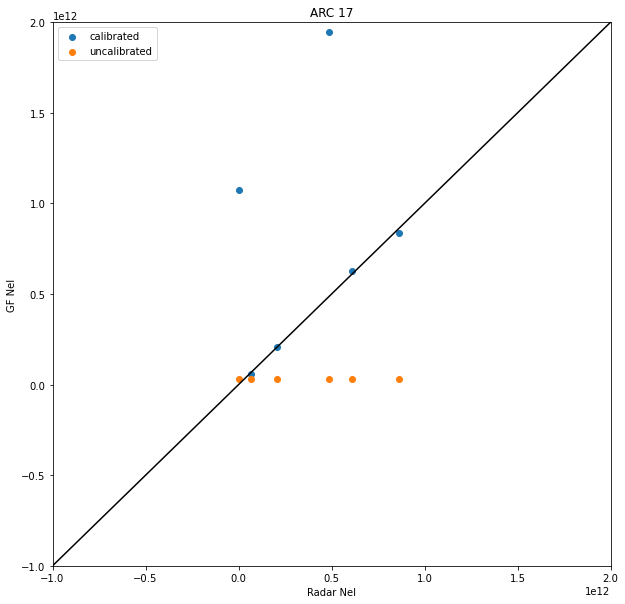

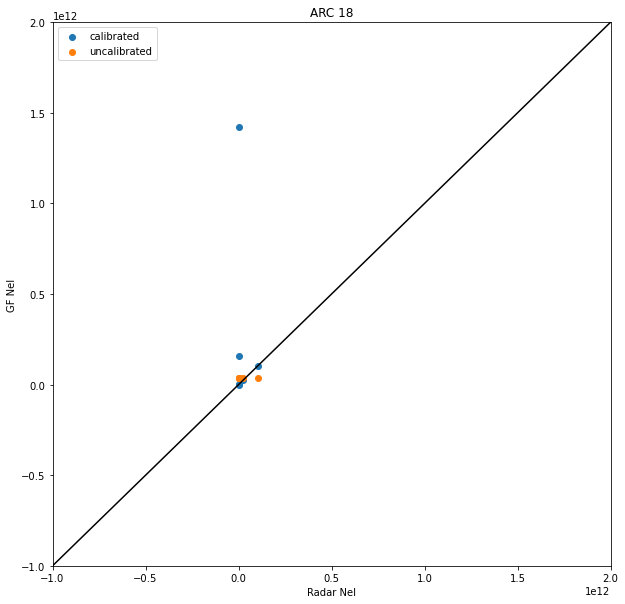

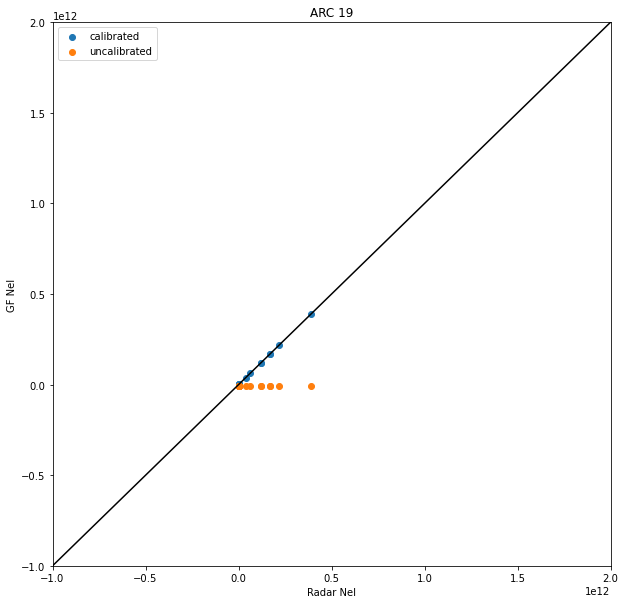

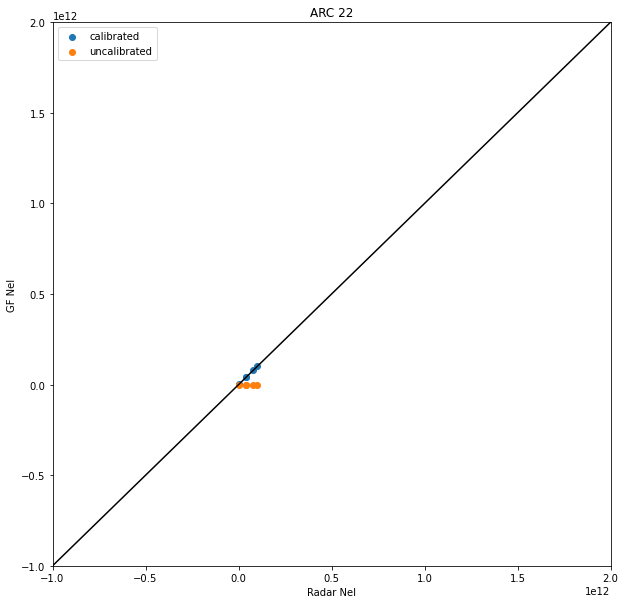

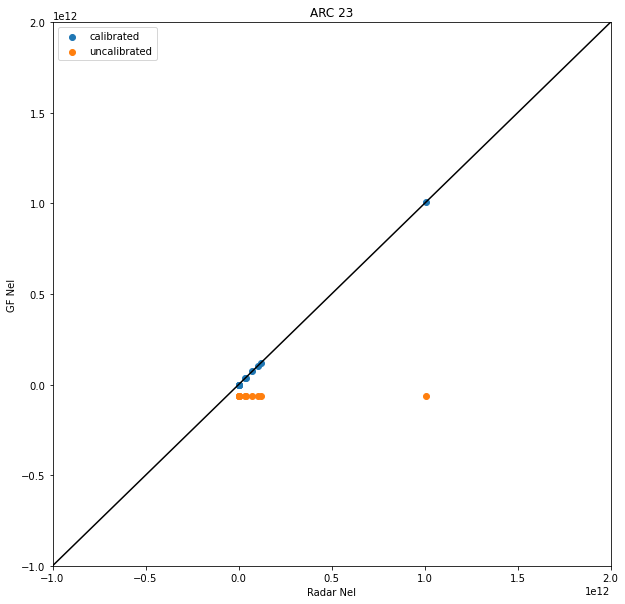

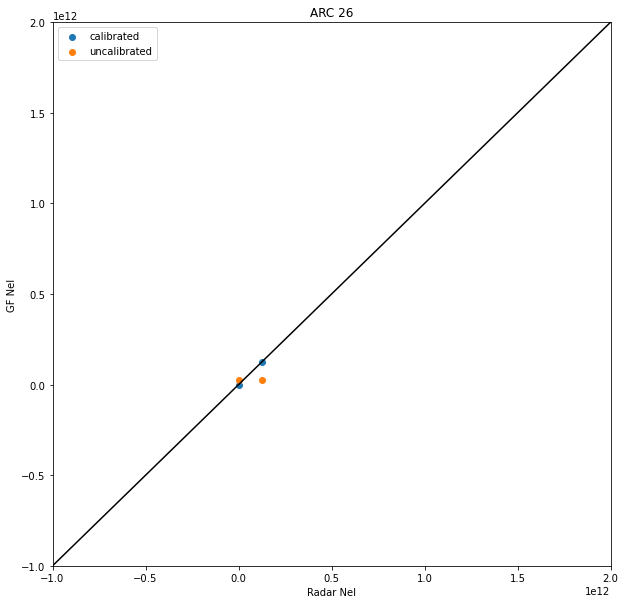

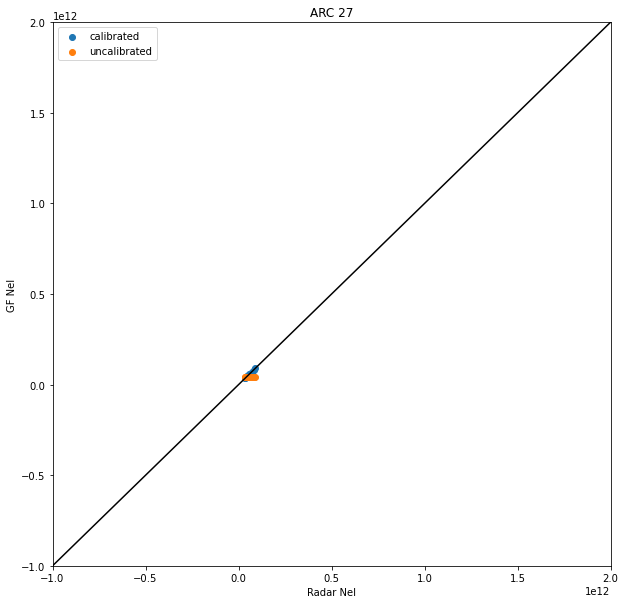

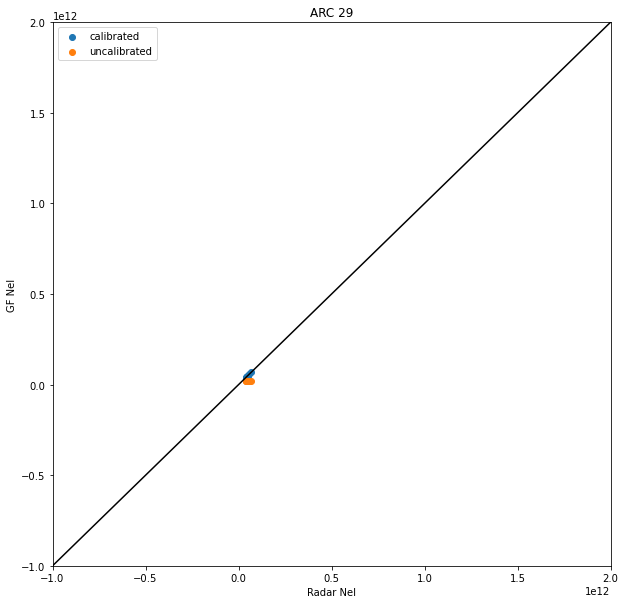

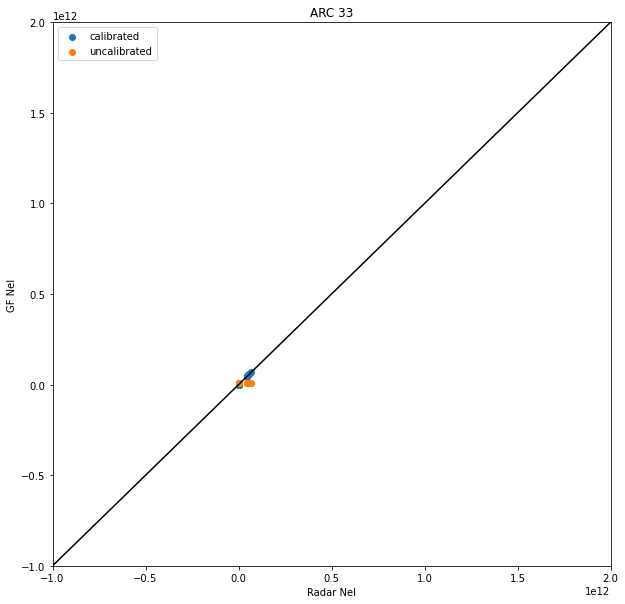

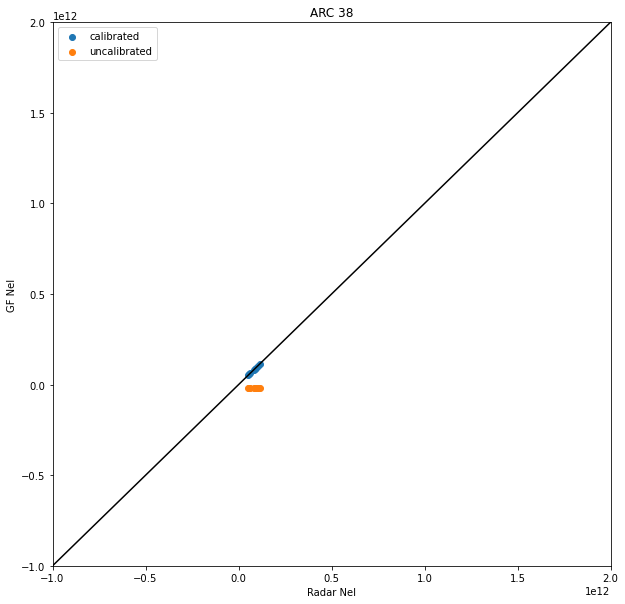

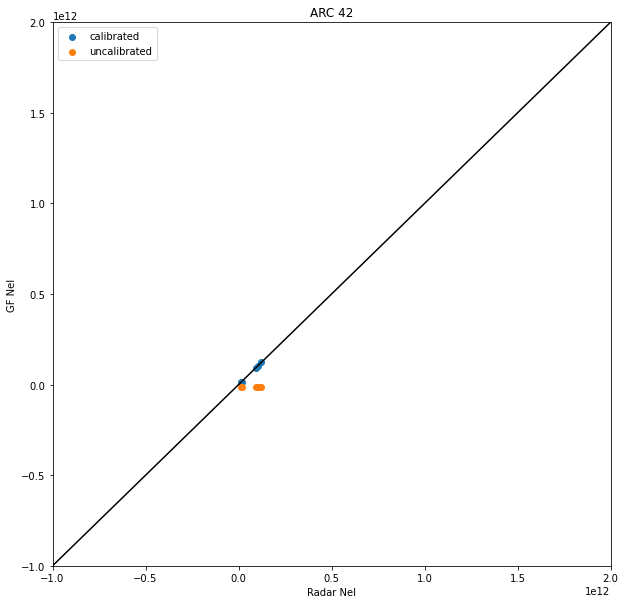

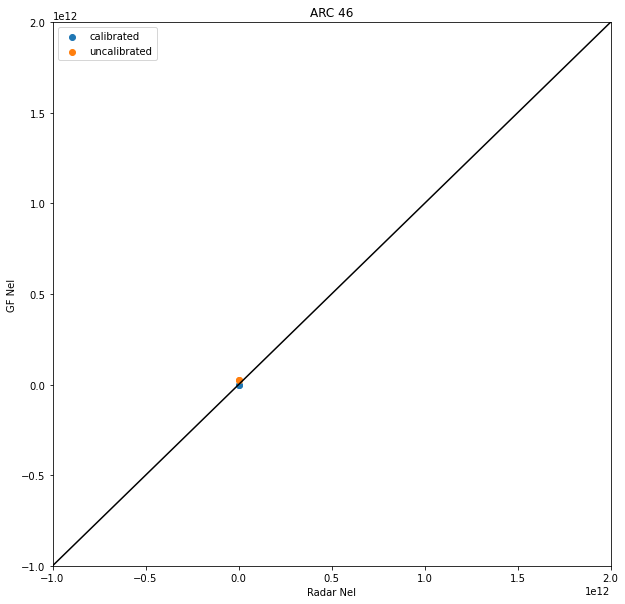

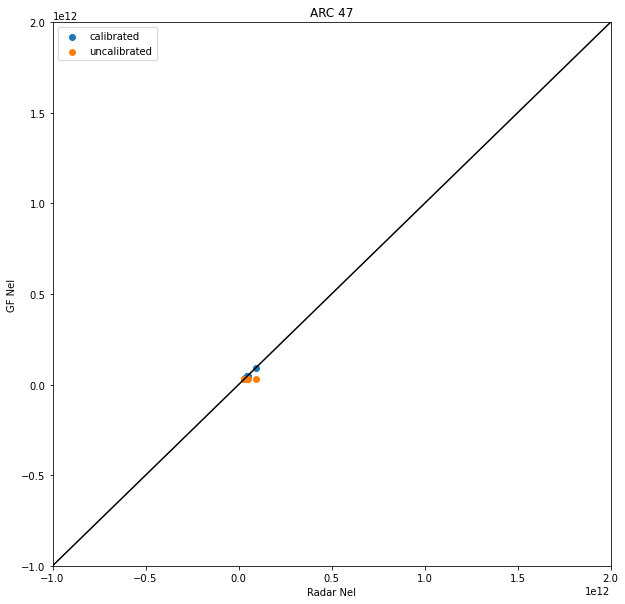

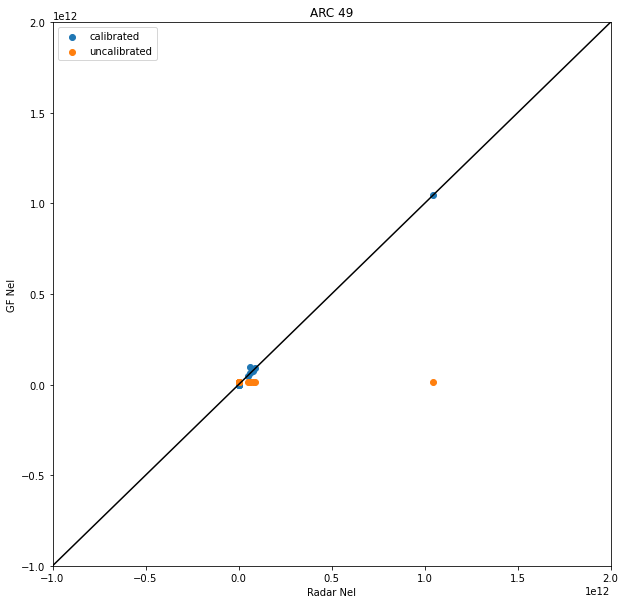

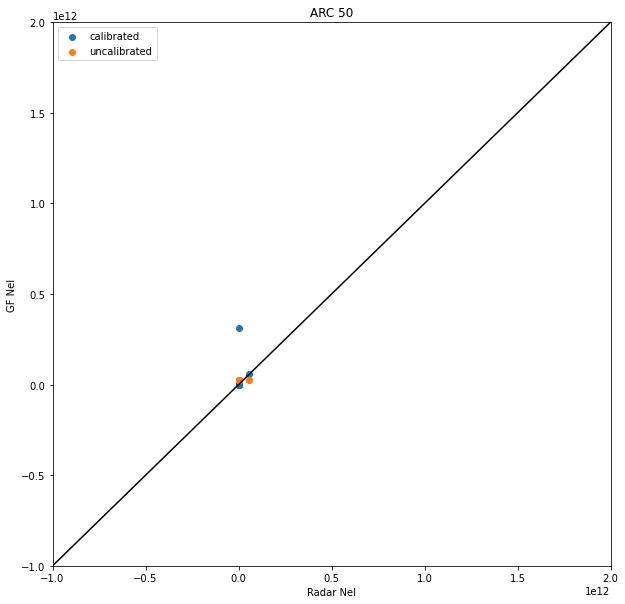

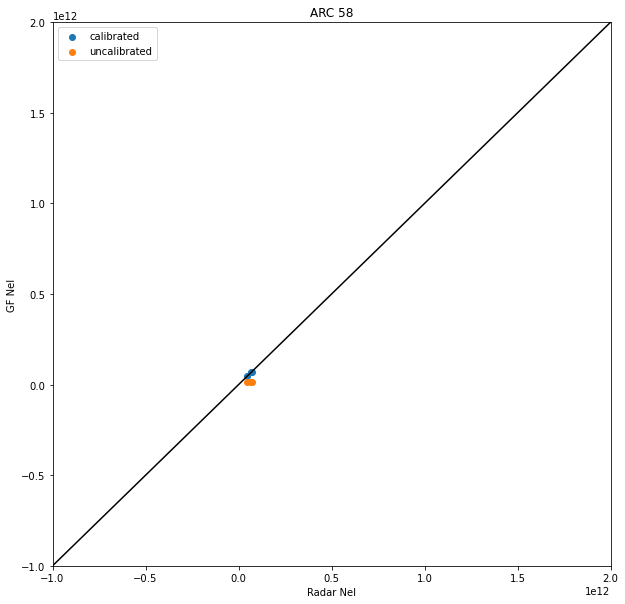

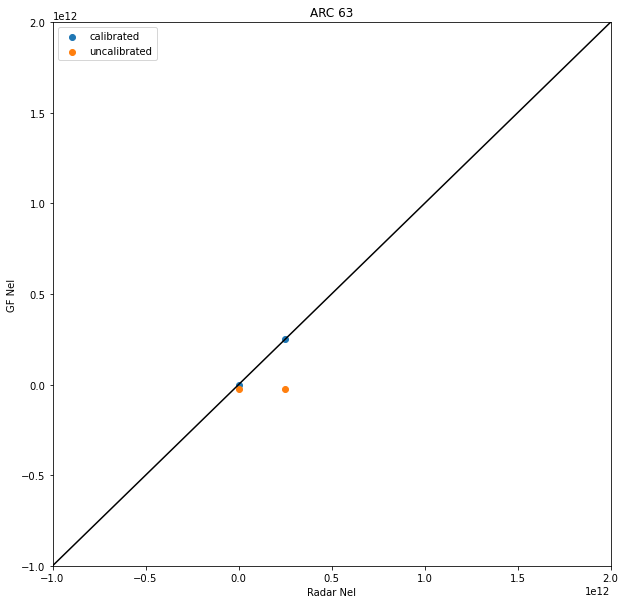

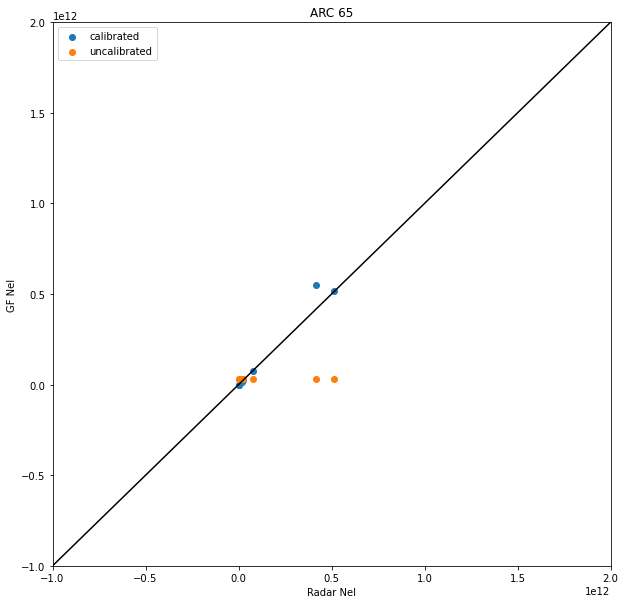

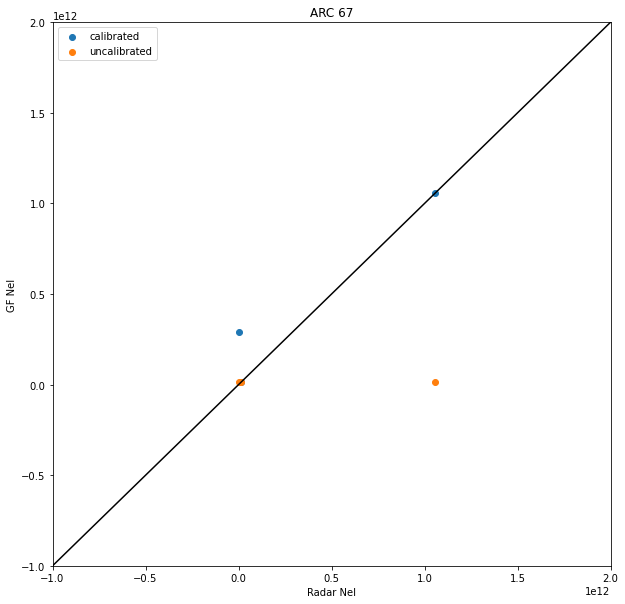

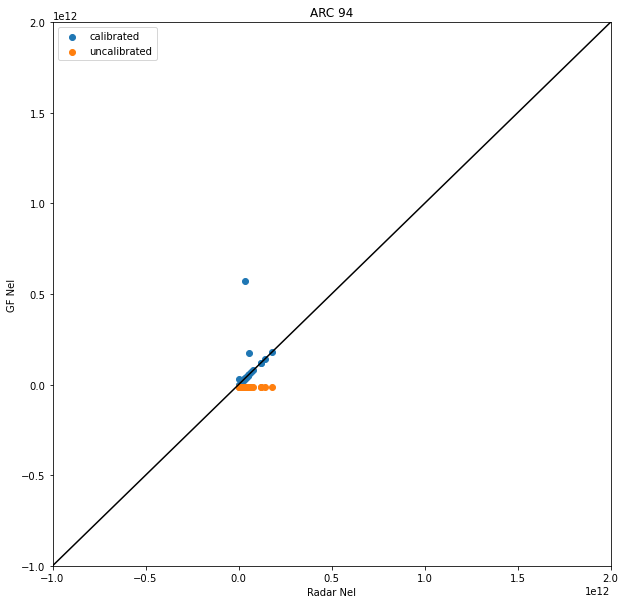

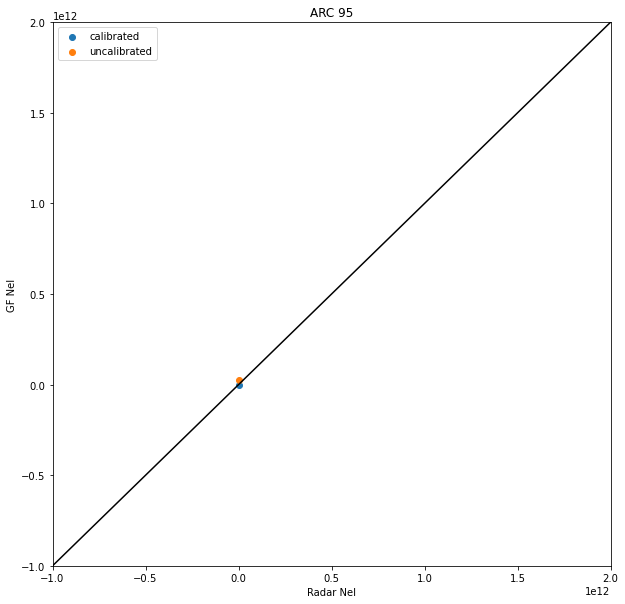

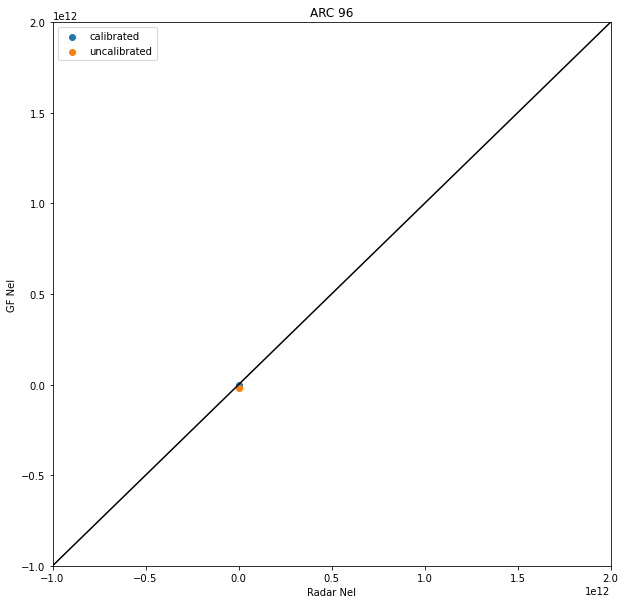

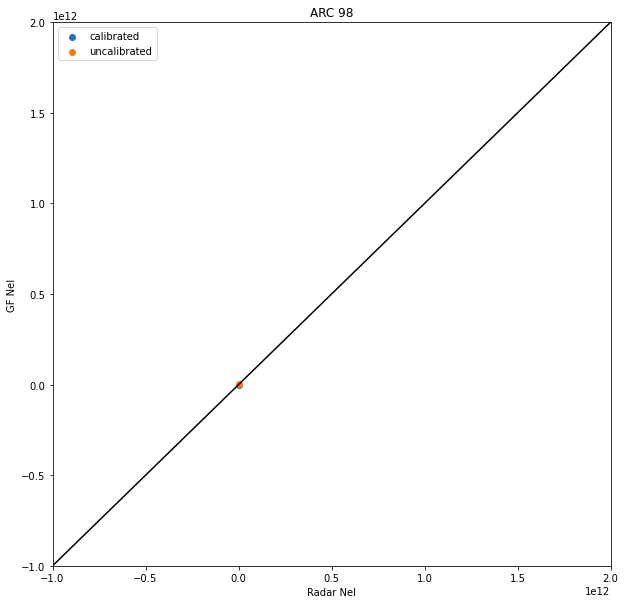

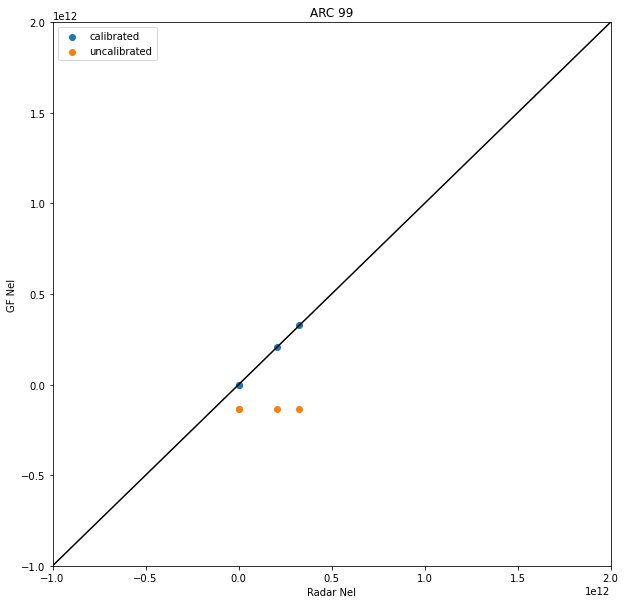

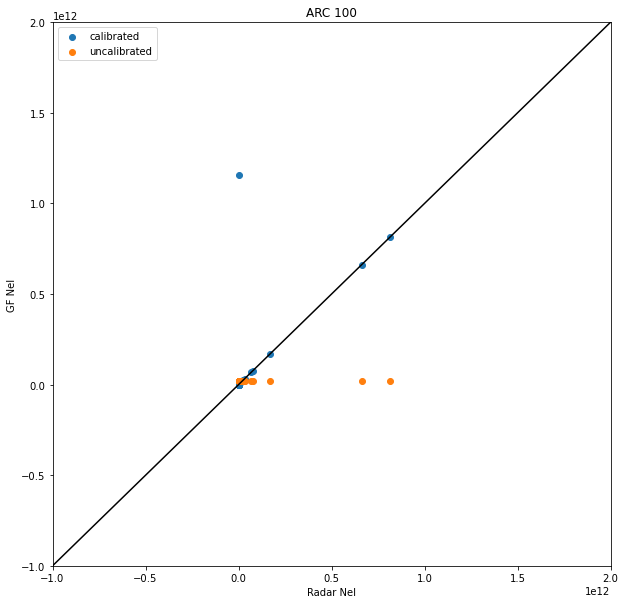

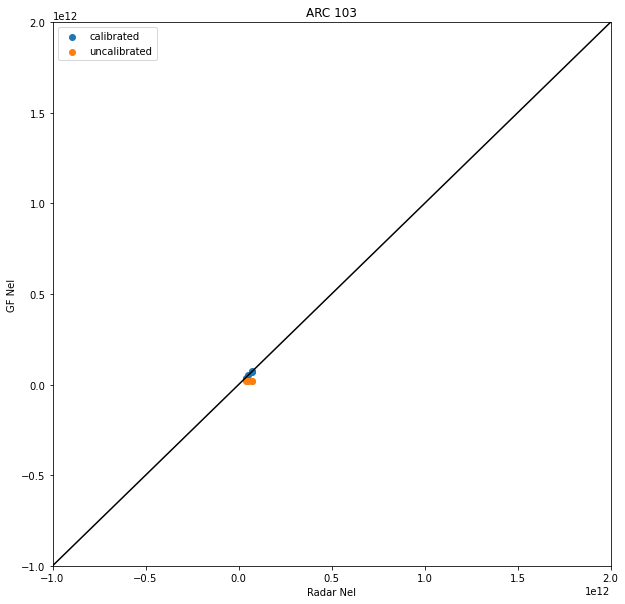

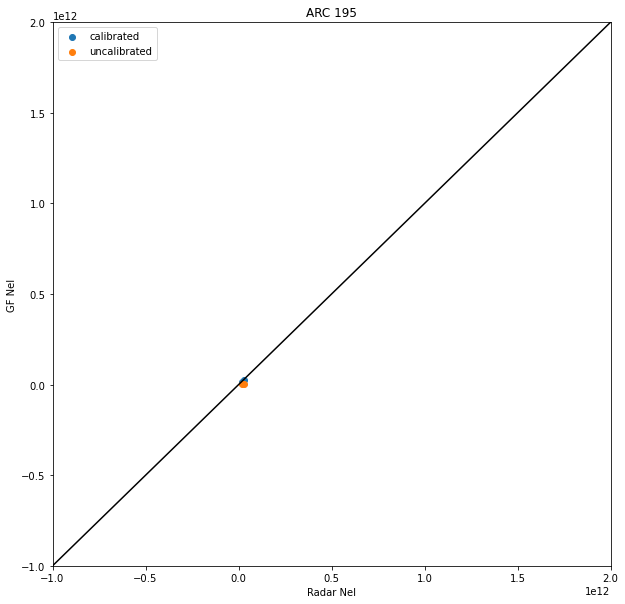

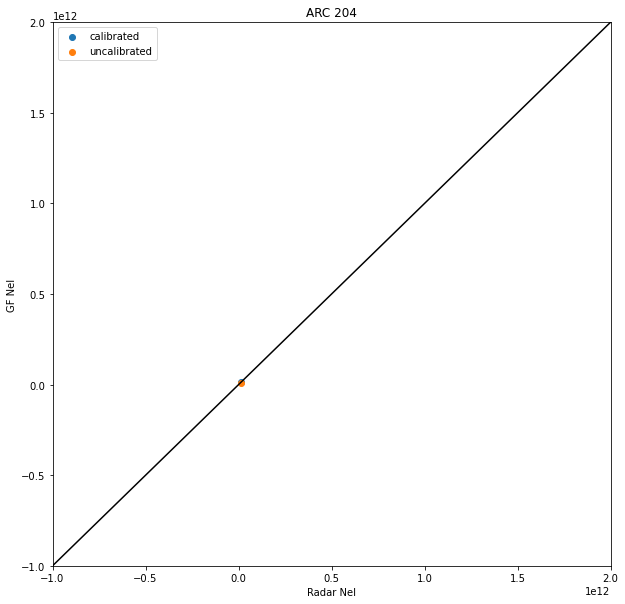

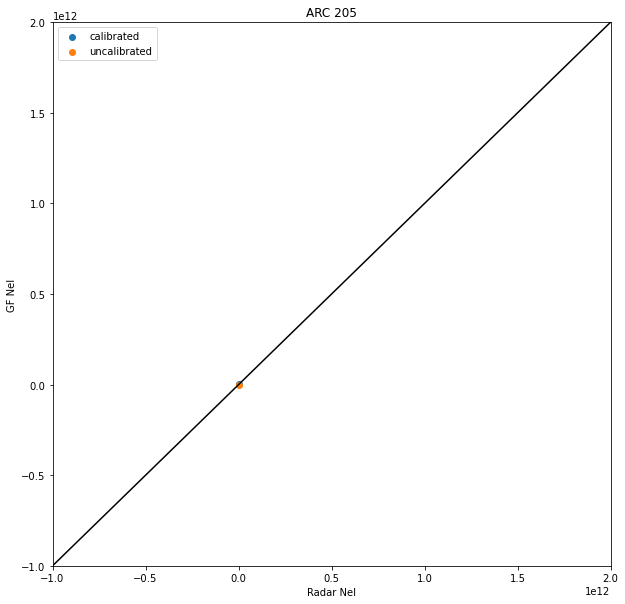

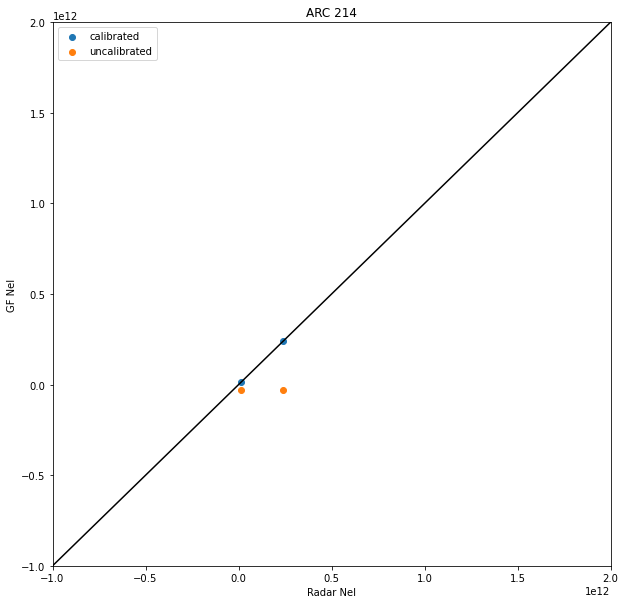

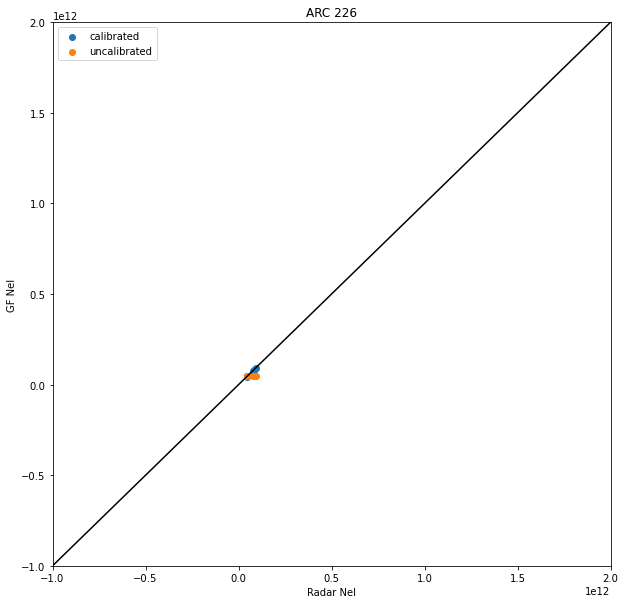

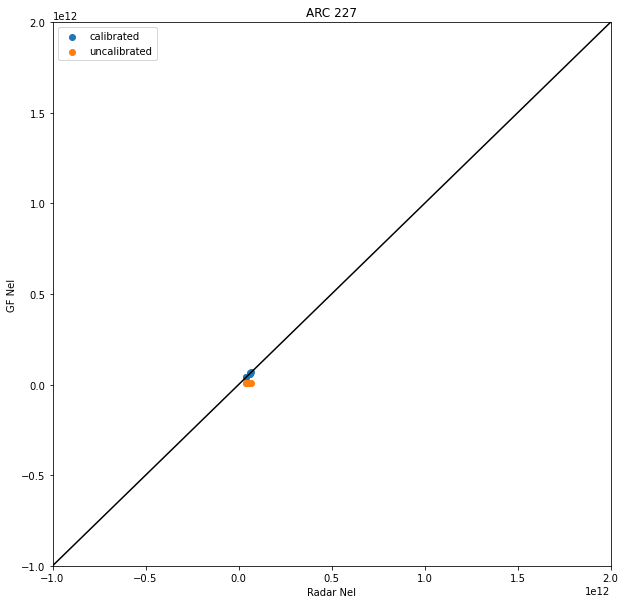

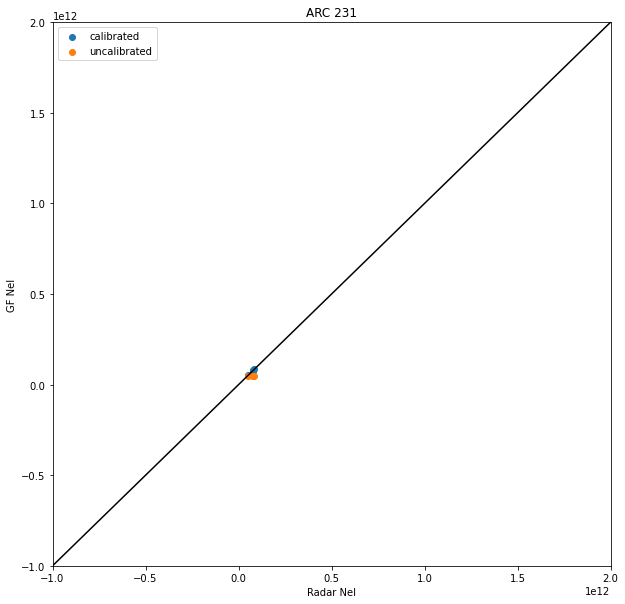

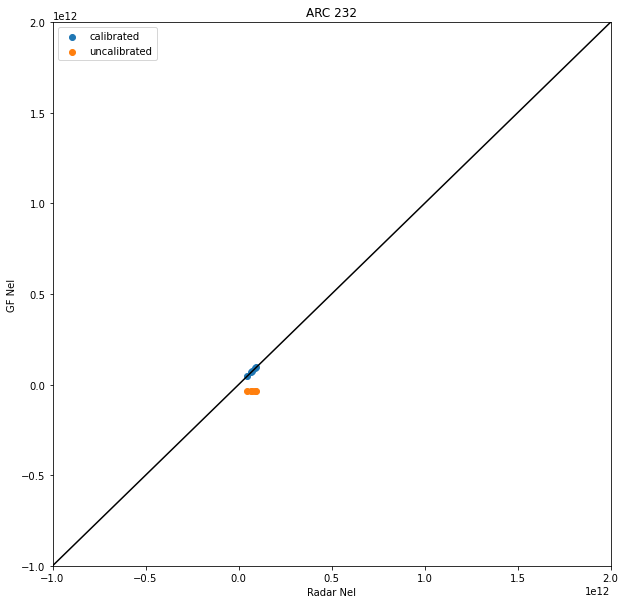

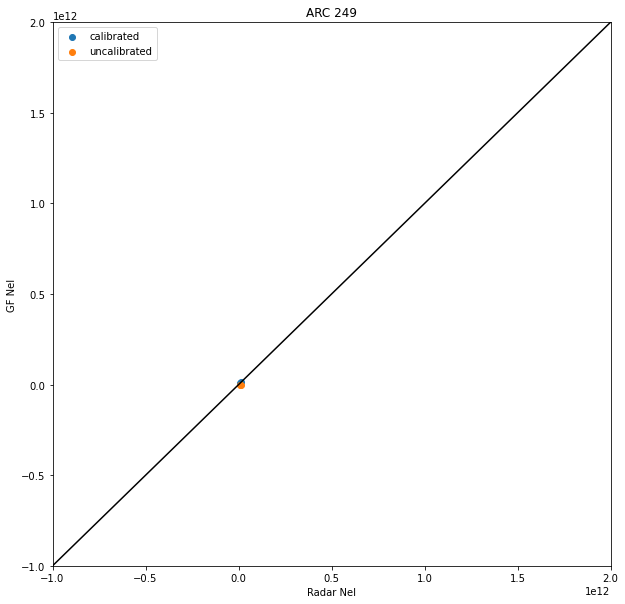

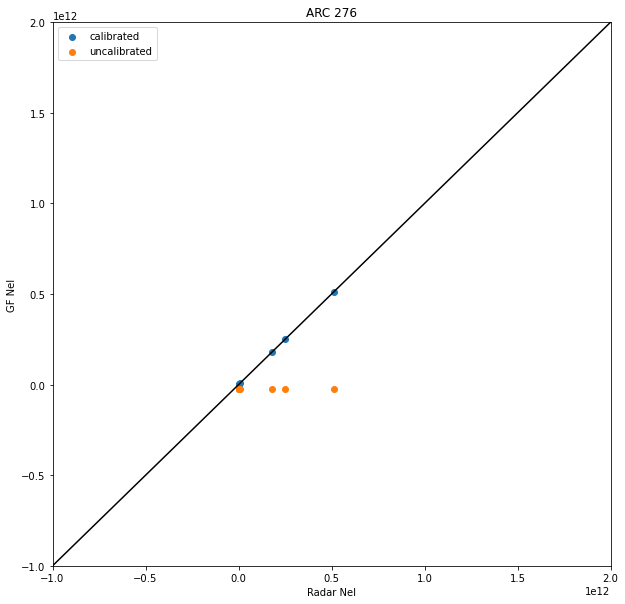

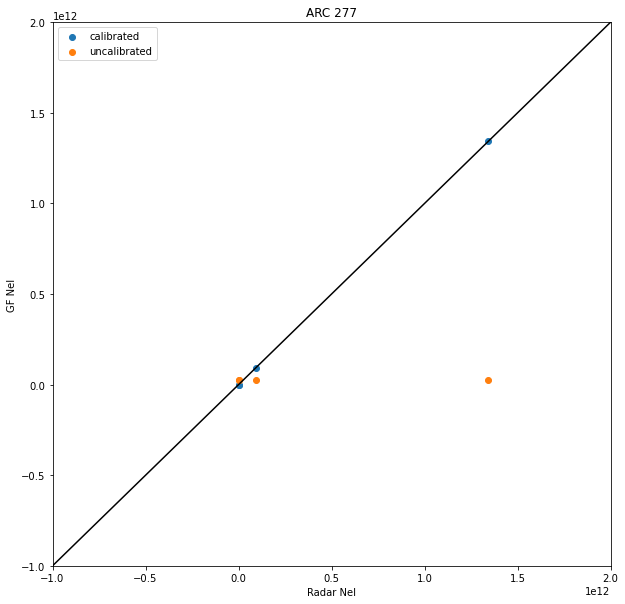

In [378]:
for arc in arcs:
    fig, ax = plt.subplots(figsize=(10,10))
    GF_RADAR_CALIB_plot = GF_RADAR_CALIB[GF_RADAR_CALIB['arc'] == arc]
    scatter = plt.scatter((GF_RADAR_CALIB_plot['radar_ne']),(GF_RADAR_CALIB_plot['gf_ne']+GF_RADAR_CALIB_plot['new_offset']), label = 'calibrated')
    scatter2 = plt.scatter((GF_RADAR_CALIB_plot['radar_ne']),(GF_RADAR_CALIB_plot['gf_ne']), label = 'uncalibrated')
    plt.xlim(-0.1e13,0.2e13)
    plt.ylim(-0.1e13,0.2e13)

    plt.legend()
    ax.axline((1, 1), slope=1, color = 'k' )
    plt.xlabel('Radar Nel')
    plt.ylabel('GF Nel')
    plt.title('ARC {n}'.format(n=arc))

In [ ]:
GF_RADAR_CALIB.to